In [1]:
!pip install gcsfs==2024.6.1
!pip install accelerate -U
!pip install transformers -U
!pip install datasets -U

# !pip install wandb
import os
# os.environ["WANDB_MODE"] = "disabled"
# os.environ["NCCL_P2P_DISABLE"] = "1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: gcsfs
    Found existing installation: gcsfs 2025.3.2
    Uninstalling gcsfs-2025.3.2:
      Successfully uninstalled gcsfs-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.

# Preprocessing Data

## Image Augmentation: Transformation

In [2]:
from transformers import ViTImageProcessor, CLIPImageProcessor, AutoImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# processor = AutoImageProcessor.from_pretrained("huggingface/densenet201")


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [3]:
import torch
def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


In [4]:
import torch

from torchvision.transforms.v2 import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomRotation,
                                    RandomCrop,
                                    RandomPerspective,
                                    RandomPhotometricDistort,
                                    RandomZoomOut,
                                    RandomInvert,
                                    RandomResizedCrop,
                                    Resize,
                                    GaussianBlur,
                                    ToTensor,
                                    ToImage,
                                    ToDtype)

image_mean, image_std = processor.image_mean, processor.image_std
height = processor.size['height']
width = processor.size['width']
normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
        [
            # CenterCrop(size*2),
            Resize((width,height)),
            # RandomInvert(p=0.01),
            RandomPhotometricDistort(p=0.1),
            RandomPerspective(distortion_scale = 0.2, p=0.2),
            RandomRotation(degrees=(-30,30)),
            # RandomPerspective(0.2),
            GaussianBlur(1),
            # CenterCrop(size),
            # RandomHorizontalFlip(),
            # ToImage(),
            ToTensor(),
            ToDtype(torch.float32, scale=True),
            # ToTensor(),
            # normalize,
        ]
    )

_val_transforms = Compose(
        [
            # CenterCrop(size*2),
            Resize((width,height)),
            # GaussianBlur(3),
            # ToImage(),
            ToTensor(),
            ToDtype(torch.float32, scale=True),
            # ToTensor(),
            # normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert('RGB')) for image in examples['image']]
    return examples



/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


In [6]:
def set_fresh_labels(example):
    example["label"] = 0
    return example
def set_sick_labels(example):
    example["label"] = 1
    return example

##Load and Split Data

In [7]:
from datasets import load_dataset,concatenate_datasets

fresh_fish_dir = "/content/drive/MyDrive/data/SalmonScan/SalmonScan/FreshFish"
sick_fish_dir = "/content/drive/MyDrive/data/SalmonScan/SalmonScan/InfectedFish"

fresh_fish_dataset = load_dataset("imagefolder", data_dir=fresh_fish_dir, keep_in_memory=True, drop_metadata=True)['train']
sick_fish_dataset = load_dataset("imagefolder", data_dir=sick_fish_dir, keep_in_memory=True, drop_metadata=True)['train']
fresh_fish_dataset = fresh_fish_dataset.map(set_fresh_labels)
sick_fish_dataset = sick_fish_dataset.map(set_sick_labels)

data_ds = concatenate_datasets([fresh_fish_dataset, sick_fish_dataset])
splits = data_ds.train_test_split(test_size=0.2)
train_ds = splits['train']
splits = splits['test'].train_test_split(test_size=0.5)
test_ds = splits['train']
val_ds = splits['test']


Resolving data files:   0%|          | 0/456 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/752 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/456 [00:00<?, ? examples/s]

Map:   0%|          | 0/752 [00:00<?, ? examples/s]

In [8]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

#Define the model


1.   DenseNet
2.   Output size = num_patterns * 5



## CLIP

In [38]:
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import CLIPModel, CLIPProcessor

import torch.nn as nn
import torch.nn.functional as F

class ClipForFishInfectionDetection(nn.Module):

    def __init__(self):

        super(ClipForFishInfectionDetection, self).__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 2)
        # Freeze CLIP encoders (so they don't get updated during training)
        # for param in self.clip.vision_model.parameters():
        #     param.requires_grad = True

        # for param in self.clip.text_model.parameters():
        #     param.requires_grad = False

    def forward(self, pixel_values, labels=None):
        #with torch.no_grad():  # Prevent gradients for CLIP backbone
        features = self.clip.get_image_features(pixel_values)
        fc1 = F.relu(self.fc1(features))
        output = self.fc2(fc1)
        # output = F.softmax(fc2, dim=1)
        loss = None
        total_loss  = 0
        if labels is not None:
          # Define custom weights for each class
          # weights = [0.2, 0.3]  # Example weights for 2 classes
          # class_weights = torch.tensor(weights, dtype=torch.float)
          # class_weights = class_weights.to(pixel_values.device)

          # Initialize the loss function with class weights
          loss_fct = nn.CrossEntropyLoss()#weight=class_weights
          total_loss = loss_fct(output, labels)
        return { 'logits': output, 'loss': total_loss }

drive_path = 'drive/MyDrive/checkpoints/fish/'

model = ClipForFishInfectionDetection()
# Load the saved state dictionary
# model.load_state_dict(torch.load(drive_path + "model-clip-v1.pth"))
model = model.to('cuda')

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

## DenseNet

In [41]:
from torchvision.models import densenet121, densenet201  # or another variant like densenet169, densenet201
from torchvision.models import DenseNet121_Weights, DenseNet201_Weights
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class DenseNetForFishInfectionDetection(nn.Module):

    def __init__(self):

        super(DenseNetForFishInfectionDetection, self).__init__()
        self.dense = densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)
        self.classifier = nn.Linear(self.dense.classifier.in_features, 2)

    def forward(self, pixel_values, labels=None):
        features = self.dense.features(pixel_values)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        output = self.classifier(out)
        # output = F.softmax(classifier, dim=1)
        loss = None
        total_loss  = 0
        if labels is not None:

          # Initialize the loss function with class weights
          loss_fct = nn.CrossEntropyLoss()#weight=class_weights
          # Calculate loss for each label separately and sum them up
          total_loss = loss_fct(output, labels)
        return { 'logits': output, 'loss': total_loss }

drive_path = 'drive/MyDrive/checkpoints/fish/'

model = DenseNetForFishInfectionDetection()
# Load the saved state dictionary
# model.load_state_dict(torch.load(drive_path + "model-densenet-v1.pth"))
model = model.to('cuda')

## ViT

In [30]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForFishInfectionDetection(nn.Module):

    def __init__(self):

        super(ViTForFishInfectionDetection, self).__init__()
        #google/vit-large-patch16-224-in21k
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier = nn.Linear(self.vit.config.hidden_size, 2)

    def forward(self, pixel_values, labels):

        vit = self.vit(pixel_values=pixel_values)
        output = self.classifier(vit.last_hidden_state[:,0])
        # output = F.softmax(classifier, dim=1)
        loss = None
        total_loss  = 0

        if labels is not None:

          loss_fct = nn.CrossEntropyLoss()
          total_loss = loss_fct(output, labels)

        return { 'logits': output, 'loss': total_loss }


drive_path = 'drive/MyDrive/checkpoints/fish/'

model = ViTForFishInfectionDetection()
# Load the saved state dictionary
# model.load_state_dict(torch.load(drive_path + "model-v1-lowdecay.pth"))
model = model.to('cuda')

# Metrics and Visulisation


In [10]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    max_prob_index = np.argmax(predictions, axis=1)
    # ************ to check the demension
    # print(max_prob_index.reshape(-1, 18), labels)
    return dict(accuracy=accuracy_score(np.reshape(labels,(-1)), max_prob_index))

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
       logits = logits[0]
    return (logits, labels)


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, r2_score
import cv2
import math
from google.colab.patches import cv2_imshow


def draw_confusion_matrix(outputs):
    show_type_labels = [0, 1]
    y_true = outputs['label_ids']
    print(y_true.shape)
    y_pred = np.argmax(outputs['prediction'], axis =1)
    print(y_pred.shape)
    mean_error = 1- outputs['accuracy']
    type_cm = confusion_matrix(np.reshape(y_true,(-1)), np.reshape(y_pred,(-1)), labels=show_type_labels)
    type_labels = ['fresh', 'sick']
    disp = ConfusionMatrixDisplay(confusion_matrix=type_cm, display_labels=type_labels)
    disp.plot(xticks_rotation=45)
    plt.title("Type based prediction for all")


def show_mislabeled_image(result, dataset, num=10):

    id_type = {0: 'fresh', 1: 'infected'}
    y_true = result['label_ids']
    y_pred = np.argmax(result['prediction'], axis =1)
    res = y_true != y_pred
    true_indices = [i for i, value in enumerate(res) if value]
    rows = (min(num, len(true_indices)) + 1 ) // 2
    plt.figure(figsize=(4 * rows, 4 * rows))
    for i in range(len(true_indices)):
        if i == num:
          break
        plt.subplot(rows, 2, i+1)
        plt.imshow(dataset[true_indices[i]]['image'])
        plt.title(f"True Lable: {id_type[dataset[true_indices[i]]['label']]} \n VS \n Prediction Lable: {id_type[y_pred[true_indices[i]]]}", fontsize=16)
        plt.axis('off')
    plt.show()



In [12]:
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import DataLoader

def predict(input):
  data_loader = DataLoader(input, batch_size=10, shuffle=False,collate_fn=collate_fn)
  loader_tqdm = tqdm(data_loader, desc="Testing", leave=False, position=0)
  model.eval()
  all_predictions = []
  all_labels = []
  loss = 0
  with torch.no_grad():
      for data in loader_tqdm:
          val_output = model(data['pixel_values'].to('cuda'), data['labels'].to('cuda'))
          all_predictions.append(val_output['logits'].cpu().numpy())
          all_labels.append(data['labels'].cpu().numpy())
          loss += val_output['loss'].item()

  all_predictions = np.concatenate(all_predictions, axis=0)
  # all_predictions = np.argmax(all_predictions, axis=1)
  all_labels = np.concatenate(all_labels, axis=0)
  accuracy = compute_metrics((all_predictions, all_labels))
  loss /= (len(input))
  return {"accuracy": accuracy['accuracy'], "avg_loss": loss, "label_ids":all_labels, "prediction":all_predictions}

#Finetuning and Evaluation

In [42]:
from torch.utils.data import DataLoader, Subset
import transformers
import torch
from tqdm import tqdm
from transformers import TrainingArguments, Trainer
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


def fine_tune(model, train_ds, val_ds, test_ds):
    metric_name = "accuracy"
    drive_path = 'drive/MyDrive/checkpoints/fish/'
    num_epochs = 10
    batch_size = 10
    train_loader = DataLoader(
        dataset=train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,  # Reduce if issues persist
        pin_memory=True  # Use for GPU training
    )
    val_loader = DataLoader(val_ds, batch_size=10, shuffle=False,collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=10, shuffle=False,collate_fn=collate_fn)
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False, position=0)


    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.1, betas=(0.9, 0.999))
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

    model = model.to('cuda')
    for i in range(num_epochs):
      print(f"Epoch {i+1}/{num_epochs}")
      train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False, position=0)
      optimizer.zero_grad()
      model.train()
      for data in train_loader_tqdm:
          output = model(data['pixel_values'].to('cuda'), data['labels'].to('cuda'))
          optimizer.zero_grad()
          loss = output['loss']
          loss.backward()
          optimizer.step()
          print(f"loss: {loss.item()}")
          train_loader_tqdm.set_postfix({"loss": f"{loss.item():.4f}"})
      model.eval()
      all_predictions = []
      all_labels = []
      with torch.no_grad():
          for val_data in val_loader:
              val_output = model(val_data['pixel_values'].to('cuda'), val_data['labels'].to('cuda'))
              all_predictions.append(val_output['logits'].cpu().numpy())
              all_labels.append(val_data['labels'].cpu().numpy())

      all_predictions = np.concatenate(all_predictions, axis=0)
      all_labels = np.concatenate(all_labels, axis=0)
      val_accuracy = compute_metrics((all_predictions, all_labels))
      print(f"Validation Accuracy: {val_accuracy['accuracy']}")
      # Step the scheduler based on the validation metric
      scheduler.step(val_accuracy['accuracy'])
    #test the model
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for test_data in test_loader:
            test_output = model(test_data['pixel_values'].to('cuda'), test_data['labels'].to('cuda'))
            all_predictions.append(test_output['logits'].cpu().numpy())
            all_labels.append(test_data['labels'].cpu().numpy())

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    test_accuracy = compute_metrics((all_predictions, all_labels))
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, np.argmax(all_predictions,axis=1), average='macro')

    print(f"Test Accuracy: {test_accuracy['accuracy']}")
    # Step the scheduler based on the validation metric
    return test_accuracy['accuracy'], precision, recall, f1

def run_cross_validation(model, data_ds):

    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    res = []
    # Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kfold.split(data_ds)):
        print(f"\nFold {fold+1}")
        print(len(train_idx))
        # Subset the dataset
        val_size = len(test_idx)
        val_idx = list(train_idx)[:val_size]
        train_idx = list(train_idx)[val_size:]
        train_subset = data_ds.select(train_idx)
        val_subset = data_ds.select(val_idx)
        test_subset = data_ds.select(test_idx)

        # Set the transforms
        train_subset.set_transform(train_transforms)
        val_subset.set_transform(val_transforms)
        test_subset.set_transform(val_transforms)

        model = DenseNetForFishInfectionDetection()
        model.to('cuda')
        test_accuracy, precision, recall, f1 = fine_tune(model, train_subset, val_subset, test_subset)
        res.append((test_accuracy, precision, recall, f1))
      # Convert to NumPy array
    metrics_array = np.array(res)
    # Compute mean and std along columns
    mean_metrics = metrics_array.mean(axis=0)
    std_metrics = metrics_array.std(axis=0)

    # Print nicely
    print(metrics_array)
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']
    for name, mean, std in zip(metric_names, mean_metrics, std_metrics):
        print(f"{name}: {mean:.4f} ± {std:.4f}")
    return res

In [43]:
res = run_cross_validation(model, data_ds)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.save(model.state_dict(), drive_path + "model-clip-v1.pth")

In [59]:
torch.cuda.empty_cache()

#Visualization

In [57]:
model = ClipForFishInfectionDetection()
model = model.to('cuda')
accuracy, precision, recall, f1 = fine_tune(model, train_ds, val_ds, test_ds)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 1/10


Training:   1%|          | 1/97 [00:00<00:26,  3.58it/s, loss=0.6904]

loss: 0.690363883972168


Training:   2%|▏         | 2/97 [00:00<00:23,  4.00it/s, loss=0.6813]

loss: 0.6812893152236938


Training:   3%|▎         | 3/97 [00:00<00:22,  4.10it/s, loss=0.6905]

loss: 0.690477728843689


Training:   4%|▍         | 4/97 [00:00<00:21,  4.27it/s, loss=0.6600]

loss: 0.6600105166435242


Training:   5%|▌         | 5/97 [00:01<00:21,  4.35it/s, loss=0.6906]

loss: 0.6905729174613953


Training:   6%|▌         | 6/97 [00:01<00:20,  4.41it/s, loss=0.6503]

loss: 0.6503267884254456


Training:   7%|▋         | 7/97 [00:01<00:19,  4.55it/s, loss=0.6918]

loss: 0.691818118095398


Training:   8%|▊         | 8/97 [00:01<00:19,  4.53it/s, loss=0.6696]

loss: 0.6695748567581177


Training:   9%|▉         | 9/97 [00:02<00:19,  4.53it/s, loss=0.6630]

loss: 0.6629545092582703


Training:  10%|█         | 10/97 [00:02<00:19,  4.48it/s, loss=0.6354]

loss: 0.6354366540908813


Training:  11%|█▏        | 11/97 [00:02<00:18,  4.53it/s, loss=0.6368]

loss: 0.6367741227149963


Training:  12%|█▏        | 12/97 [00:02<00:18,  4.57it/s, loss=0.6805]

loss: 0.6805371046066284


Training:  13%|█▎        | 13/97 [00:02<00:18,  4.62it/s, loss=0.6534]

loss: 0.6534331440925598


Training:  14%|█▍        | 14/97 [00:03<00:18,  4.60it/s, loss=0.6544]

loss: 0.6543937921524048


Training:  15%|█▌        | 15/97 [00:03<00:17,  4.64it/s, loss=0.5978]

loss: 0.5977817177772522


Training:  16%|█▋        | 16/97 [00:03<00:18,  4.36it/s, loss=0.6766]

loss: 0.6765880584716797


Training:  18%|█▊        | 17/97 [00:03<00:19,  4.12it/s, loss=0.6115]

loss: 0.6115230917930603


Training:  19%|█▊        | 18/97 [00:04<00:19,  4.07it/s, loss=0.6402]

loss: 0.6402192711830139


Training:  20%|█▉        | 19/97 [00:04<00:19,  4.03it/s, loss=0.6624]

loss: 0.6623605489730835


Training:  21%|██        | 20/97 [00:04<00:19,  3.90it/s, loss=0.5991]

loss: 0.5990875959396362


Training:  22%|██▏       | 21/97 [00:04<00:19,  3.94it/s, loss=0.6037]

loss: 0.6037299633026123


Training:  23%|██▎       | 22/97 [00:05<00:19,  3.94it/s, loss=0.5927]

loss: 0.5927122831344604


Training:  24%|██▎       | 23/97 [00:05<00:19,  3.89it/s, loss=0.5945]

loss: 0.5945254564285278


Training:  25%|██▍       | 24/97 [00:05<00:19,  3.82it/s, loss=0.6108]

loss: 0.6107920408248901


Training:  26%|██▌       | 25/97 [00:05<00:18,  3.81it/s, loss=0.5497]

loss: 0.5496923923492432


Training:  27%|██▋       | 26/97 [00:06<00:18,  3.75it/s, loss=0.5613]

loss: 0.561295211315155


Training:  28%|██▊       | 27/97 [00:06<00:18,  3.77it/s, loss=0.5965]

loss: 0.5965269804000854


Training:  29%|██▉       | 28/97 [00:06<00:17,  3.93it/s, loss=0.6367]

loss: 0.6367380619049072


Training:  30%|██▉       | 29/97 [00:06<00:16,  4.11it/s, loss=0.5370]

loss: 0.5370012521743774


Training:  31%|███       | 30/97 [00:07<00:15,  4.24it/s, loss=0.5794]

loss: 0.5794383883476257


Training:  32%|███▏      | 31/97 [00:07<00:15,  4.34it/s, loss=0.5183]

loss: 0.5182877779006958


Training:  33%|███▎      | 32/97 [00:07<00:19,  3.29it/s, loss=0.5518]

loss: 0.5518429279327393


Training:  34%|███▍      | 33/97 [00:08<00:22,  2.89it/s, loss=0.5461]

loss: 0.5461199879646301


Training:  35%|███▌      | 34/97 [00:08<00:19,  3.24it/s, loss=0.5447]

loss: 0.5446869134902954


Training:  36%|███▌      | 35/97 [00:08<00:17,  3.58it/s, loss=0.5616]

loss: 0.5616167187690735


Training:  37%|███▋      | 36/97 [00:08<00:16,  3.80it/s, loss=0.5237]

loss: 0.5236724019050598


Training:  38%|███▊      | 37/97 [00:09<00:14,  4.02it/s, loss=0.5252]

loss: 0.525195837020874


Training:  39%|███▉      | 38/97 [00:09<00:14,  4.18it/s, loss=0.5099]

loss: 0.5098554491996765


Training:  40%|████      | 39/97 [00:09<00:13,  4.17it/s, loss=0.4725]

loss: 0.47248736023902893


Training:  41%|████      | 40/97 [00:09<00:13,  4.26it/s, loss=0.6586]

loss: 0.6585876941680908


Training:  42%|████▏     | 41/97 [00:10<00:12,  4.43it/s, loss=0.6221]

loss: 0.6220853924751282


Training:  43%|████▎     | 42/97 [00:10<00:12,  4.48it/s, loss=0.5070]

loss: 0.5069896578788757


Training:  44%|████▍     | 43/97 [00:10<00:11,  4.55it/s, loss=0.4725]

loss: 0.47247377038002014


Training:  45%|████▌     | 44/97 [00:10<00:11,  4.56it/s, loss=0.5332]

loss: 0.5331861972808838


Training:  46%|████▋     | 45/97 [00:10<00:11,  4.65it/s, loss=0.5434]

loss: 0.5433863997459412


Training:  47%|████▋     | 46/97 [00:11<00:11,  4.56it/s, loss=0.4352]

loss: 0.43523597717285156


Training:  48%|████▊     | 47/97 [00:11<00:10,  4.61it/s, loss=0.4662]

loss: 0.4661850333213806


Training:  49%|████▉     | 48/97 [00:11<00:10,  4.59it/s, loss=0.4499]

loss: 0.4499289095401764


Training:  51%|█████     | 49/97 [00:11<00:10,  4.68it/s, loss=0.6029]

loss: 0.6028587818145752


Training:  52%|█████▏    | 50/97 [00:12<00:09,  4.70it/s, loss=0.5515]

loss: 0.5515176653862


Training:  53%|█████▎    | 51/97 [00:12<00:09,  4.73it/s, loss=0.4832]

loss: 0.48315826058387756


Training:  54%|█████▎    | 52/97 [00:12<00:09,  4.64it/s, loss=0.4543]

loss: 0.4542528986930847


Training:  55%|█████▍    | 53/97 [00:12<00:09,  4.43it/s, loss=0.4347]

loss: 0.43466368317604065


Training:  56%|█████▌    | 54/97 [00:12<00:09,  4.46it/s, loss=0.5422]

loss: 0.5422259569168091


Training:  57%|█████▋    | 55/97 [00:13<00:09,  4.45it/s, loss=0.4517]

loss: 0.4516873359680176


Training:  58%|█████▊    | 56/97 [00:13<00:09,  4.49it/s, loss=0.5869]

loss: 0.5868508219718933


Training:  59%|█████▉    | 57/97 [00:13<00:08,  4.54it/s, loss=0.4192]

loss: 0.4191659390926361


Training:  60%|█████▉    | 58/97 [00:13<00:08,  4.61it/s, loss=0.5336]

loss: 0.5336341857910156


Training:  61%|██████    | 59/97 [00:13<00:08,  4.64it/s, loss=0.4695]

loss: 0.46954983472824097


Training:  62%|██████▏   | 60/97 [00:14<00:08,  4.50it/s, loss=0.4071]

loss: 0.4070819020271301


Training:  63%|██████▎   | 61/97 [00:14<00:08,  4.48it/s, loss=0.5959]

loss: 0.5958765745162964


Training:  64%|██████▍   | 62/97 [00:14<00:07,  4.53it/s, loss=0.4149]

loss: 0.41490259766578674


Training:  65%|██████▍   | 63/97 [00:14<00:07,  4.46it/s, loss=0.4785]

loss: 0.47854095697402954


Training:  66%|██████▌   | 64/97 [00:15<00:07,  4.48it/s, loss=0.4058]

loss: 0.405789315700531


Training:  67%|██████▋   | 65/97 [00:15<00:07,  4.51it/s, loss=0.4167]

loss: 0.41665250062942505


Training:  68%|██████▊   | 66/97 [00:15<00:07,  4.34it/s, loss=0.3944]

loss: 0.3944183588027954


Training:  69%|██████▉   | 67/97 [00:15<00:07,  4.05it/s, loss=0.4033]

loss: 0.4033052921295166


Training:  70%|███████   | 68/97 [00:16<00:07,  3.98it/s, loss=0.4410]

loss: 0.44103389978408813


Training:  71%|███████   | 69/97 [00:16<00:07,  3.85it/s, loss=0.4033]

loss: 0.40331268310546875


Training:  72%|███████▏  | 70/97 [00:16<00:07,  3.77it/s, loss=0.5687]

loss: 0.5686668157577515


Training:  73%|███████▎  | 71/97 [00:17<00:07,  3.33it/s, loss=0.4652]

loss: 0.4651980996131897


Training:  74%|███████▍  | 72/97 [00:17<00:08,  2.97it/s, loss=0.4785]

loss: 0.4784708023071289


Training:  75%|███████▌  | 73/97 [00:17<00:08,  2.70it/s, loss=0.4820]

loss: 0.48195895552635193


Training:  76%|███████▋  | 74/97 [00:18<00:08,  2.60it/s, loss=0.6777]

loss: 0.6777203679084778


Training:  77%|███████▋  | 75/97 [00:18<00:07,  2.88it/s, loss=0.5180]

loss: 0.5179776549339294


Training:  78%|███████▊  | 76/97 [00:18<00:06,  3.08it/s, loss=0.4554]

loss: 0.45539936423301697


Training:  79%|███████▉  | 77/97 [00:19<00:06,  3.25it/s, loss=0.5299]

loss: 0.5298552513122559


Training:  80%|████████  | 78/97 [00:19<00:05,  3.40it/s, loss=0.6657]

loss: 0.6657196879386902


Training:  81%|████████▏ | 79/97 [00:19<00:05,  3.54it/s, loss=0.4624]

loss: 0.4624359607696533


Training:  82%|████████▏ | 80/97 [00:19<00:04,  3.53it/s, loss=0.4657]

loss: 0.46566563844680786


Training:  84%|████████▎ | 81/97 [00:20<00:04,  3.63it/s, loss=0.4574]

loss: 0.4573799669742584


Training:  85%|████████▍ | 82/97 [00:20<00:03,  3.82it/s, loss=0.5047]

loss: 0.5047197341918945


Training:  86%|████████▌ | 83/97 [00:20<00:03,  4.06it/s, loss=0.3879]

loss: 0.38786762952804565


Training:  87%|████████▋ | 84/97 [00:20<00:03,  4.16it/s, loss=0.3904]

loss: 0.3904077708721161


Training:  88%|████████▊ | 85/97 [00:21<00:02,  4.24it/s, loss=0.4021]

loss: 0.40213537216186523


Training:  89%|████████▊ | 86/97 [00:21<00:02,  4.32it/s, loss=0.4670]

loss: 0.4669896960258484


Training:  90%|████████▉ | 87/97 [00:21<00:02,  4.35it/s, loss=0.5200]

loss: 0.5200124979019165


Training:  91%|█████████ | 88/97 [00:21<00:02,  4.40it/s, loss=0.4311]

loss: 0.4310797154903412


Training:  92%|█████████▏| 89/97 [00:22<00:01,  4.44it/s, loss=0.3702]

loss: 0.3702353835105896


Training:  93%|█████████▎| 90/97 [00:22<00:01,  4.53it/s, loss=0.3813]

loss: 0.3813017010688782


Training:  94%|█████████▍| 91/97 [00:22<00:01,  4.60it/s, loss=0.4797]

loss: 0.47969093918800354


Training:  95%|█████████▍| 92/97 [00:22<00:01,  4.64it/s, loss=0.3888]

loss: 0.3887838125228882


Training:  96%|█████████▌| 93/97 [00:22<00:00,  4.65it/s, loss=0.4436]

loss: 0.44358062744140625


Training:  97%|█████████▋| 94/97 [00:23<00:00,  4.56it/s, loss=0.5850]

loss: 0.5850475430488586


Training:  98%|█████████▊| 95/97 [00:23<00:00,  4.57it/s, loss=0.3700]

loss: 0.36998850107192993


loss: 0.44959574937820435
loss: 0.4116046726703644


Validation Accuracy: 0.9008264462809917
Epoch 2/10


Training:   1%|          | 1/97 [00:00<00:20,  4.65it/s, loss=0.5647]

loss: 0.5647459030151367


Training:   2%|▏         | 2/97 [00:00<00:20,  4.66it/s, loss=0.4041]

loss: 0.4040558934211731


Training:   3%|▎         | 3/97 [00:00<00:20,  4.61it/s, loss=0.5255]

loss: 0.525534451007843


Training:   4%|▍         | 4/97 [00:00<00:20,  4.56it/s, loss=0.6131]

loss: 0.6131335496902466


Training:   5%|▌         | 5/97 [00:01<00:20,  4.60it/s, loss=0.4560]

loss: 0.45602184534072876


Training:   6%|▌         | 6/97 [00:01<00:20,  4.49it/s, loss=0.6706]

loss: 0.6706483960151672


Training:   7%|▋         | 7/97 [00:01<00:19,  4.55it/s, loss=0.8619]

loss: 0.8619250059127808


Training:   8%|▊         | 8/97 [00:01<00:19,  4.58it/s, loss=0.6750]

loss: 0.6749597787857056


Training:   9%|▉         | 9/97 [00:01<00:19,  4.61it/s, loss=0.6411]

loss: 0.641126275062561


Training:  10%|█         | 10/97 [00:02<00:18,  4.58it/s, loss=0.6056]

loss: 0.605563759803772


Training:  11%|█▏        | 11/97 [00:02<00:19,  4.51it/s, loss=0.5030]

loss: 0.5030471086502075


Training:  12%|█▏        | 12/97 [00:02<00:18,  4.51it/s, loss=0.4663]

loss: 0.4662902355194092


Training:  13%|█▎        | 13/97 [00:02<00:19,  4.37it/s, loss=0.5256]

loss: 0.5256268382072449


Training:  14%|█▍        | 14/97 [00:03<00:18,  4.40it/s, loss=0.3818]

loss: 0.38181668519973755


Training:  15%|█▌        | 15/97 [00:03<00:18,  4.44it/s, loss=0.5965]

loss: 0.5965331792831421


Training:  16%|█▋        | 16/97 [00:03<00:18,  4.49it/s, loss=0.7515]

loss: 0.7515445351600647


Training:  18%|█▊        | 17/97 [00:03<00:19,  4.09it/s, loss=0.4336]

loss: 0.4335731863975525


Training:  19%|█▊        | 18/97 [00:04<00:21,  3.63it/s, loss=0.5259]

loss: 0.5258673429489136


Training:  20%|█▉        | 19/97 [00:04<00:27,  2.88it/s, loss=0.6784]

loss: 0.6783887147903442


Training:  21%|██        | 20/97 [00:05<00:33,  2.30it/s, loss=0.5982]

loss: 0.5982495546340942


Training:  22%|██▏       | 21/97 [00:06<00:44,  1.73it/s, loss=0.6013]

loss: 0.6012753844261169


Training:  23%|██▎       | 22/97 [00:07<00:47,  1.59it/s, loss=0.5167]

loss: 0.5166617631912231


Training:  24%|██▎       | 23/97 [00:07<00:42,  1.75it/s, loss=0.8209]

loss: 0.8209354281425476


Training:  25%|██▍       | 24/97 [00:07<00:41,  1.78it/s, loss=0.6433]

loss: 0.6433142423629761


Training:  26%|██▌       | 25/97 [00:08<00:43,  1.67it/s, loss=0.6450]

loss: 0.644991934299469


Training:  27%|██▋       | 26/97 [00:09<00:39,  1.80it/s, loss=0.5842]

loss: 0.5842088460922241


Training:  28%|██▊       | 27/97 [00:09<00:37,  1.88it/s, loss=0.5209]

loss: 0.5209193825721741


Training:  29%|██▉       | 28/97 [00:09<00:33,  2.09it/s, loss=0.5199]

loss: 0.5198718905448914


Training:  30%|██▉       | 29/97 [00:10<00:29,  2.27it/s, loss=0.5448]

loss: 0.5448397397994995


Training:  31%|███       | 30/97 [00:10<00:27,  2.46it/s, loss=0.5055]

loss: 0.5055257081985474


Training:  32%|███▏      | 31/97 [00:10<00:22,  2.88it/s, loss=0.5317]

loss: 0.5317055583000183


Training:  33%|███▎      | 32/97 [00:11<00:20,  3.24it/s, loss=0.4789]

loss: 0.4789148271083832


Training:  34%|███▍      | 33/97 [00:11<00:18,  3.55it/s, loss=0.4533]

loss: 0.453298419713974


Training:  35%|███▌      | 34/97 [00:11<00:16,  3.83it/s, loss=0.4985]

loss: 0.498541921377182


Training:  36%|███▌      | 35/97 [00:11<00:15,  3.94it/s, loss=0.5326]

loss: 0.5326070189476013


Training:  37%|███▋      | 36/97 [00:11<00:14,  4.07it/s, loss=0.4578]

loss: 0.45783719420433044


Training:  38%|███▊      | 37/97 [00:12<00:14,  4.23it/s, loss=0.5955]

loss: 0.5954917073249817


Training:  39%|███▉      | 38/97 [00:12<00:13,  4.40it/s, loss=0.3915]

loss: 0.39145368337631226


Training:  40%|████      | 39/97 [00:12<00:13,  4.38it/s, loss=0.5085]

loss: 0.5085259675979614


Training:  41%|████      | 40/97 [00:12<00:12,  4.40it/s, loss=0.4380]

loss: 0.4379962086677551


Training:  42%|████▏     | 41/97 [00:13<00:12,  4.44it/s, loss=0.3764]

loss: 0.37638166546821594


Training:  43%|████▎     | 42/97 [00:13<00:12,  4.36it/s, loss=0.4682]

loss: 0.46816492080688477


Training:  44%|████▍     | 43/97 [00:13<00:12,  4.40it/s, loss=0.4549]

loss: 0.4549172818660736


Training:  45%|████▌     | 44/97 [00:13<00:11,  4.44it/s, loss=0.6018]

loss: 0.6017807126045227


Training:  46%|████▋     | 45/97 [00:13<00:11,  4.46it/s, loss=0.5975]

loss: 0.5974804759025574


Training:  47%|████▋     | 46/97 [00:14<00:11,  4.49it/s, loss=0.4169]

loss: 0.4168938100337982


Training:  48%|████▊     | 47/97 [00:14<00:10,  4.55it/s, loss=0.3700]

loss: 0.3699641227722168


Training:  49%|████▉     | 48/97 [00:14<00:10,  4.55it/s, loss=0.5644]

loss: 0.5644477605819702


Training:  51%|█████     | 49/97 [00:14<00:10,  4.48it/s, loss=0.4354]

loss: 0.4353918433189392


Training:  52%|█████▏    | 50/97 [00:15<00:10,  4.50it/s, loss=0.3762]

loss: 0.3761865496635437


Training:  53%|█████▎    | 51/97 [00:15<00:10,  4.59it/s, loss=0.3669]

loss: 0.36693277955055237


Training:  54%|█████▎    | 52/97 [00:15<00:09,  4.57it/s, loss=0.3641]

loss: 0.3640819191932678


Training:  55%|█████▍    | 53/97 [00:15<00:09,  4.55it/s, loss=0.3600]

loss: 0.3600098192691803


Training:  56%|█████▌    | 54/97 [00:15<00:09,  4.53it/s, loss=0.5398]

loss: 0.5398372411727905


Training:  57%|█████▋    | 55/97 [00:16<00:09,  4.48it/s, loss=0.4439]

loss: 0.44391196966171265


Training:  58%|█████▊    | 56/97 [00:16<00:09,  4.42it/s, loss=0.6210]

loss: 0.6209696531295776


Training:  59%|█████▉    | 57/97 [00:16<00:09,  4.25it/s, loss=0.3609]

loss: 0.36087149381637573


Training:  60%|█████▉    | 58/97 [00:16<00:08,  4.35it/s, loss=0.3558]

loss: 0.35578444600105286


Training:  61%|██████    | 59/97 [00:17<00:08,  4.41it/s, loss=0.4384]

loss: 0.4383774399757385


Training:  62%|██████▏   | 60/97 [00:17<00:08,  4.43it/s, loss=0.4011]

loss: 0.4011248052120209


Training:  63%|██████▎   | 61/97 [00:17<00:08,  4.44it/s, loss=0.3537]

loss: 0.3536527156829834


Training:  64%|██████▍   | 62/97 [00:17<00:07,  4.48it/s, loss=0.5296]

loss: 0.5296271443367004


Training:  65%|██████▍   | 63/97 [00:17<00:07,  4.44it/s, loss=0.4370]

loss: 0.43697887659072876


Training:  66%|██████▌   | 64/97 [00:18<00:07,  4.44it/s, loss=0.3594]

loss: 0.359435498714447


Training:  67%|██████▋   | 65/97 [00:18<00:07,  4.49it/s, loss=0.3741]

loss: 0.37405118346214294


Training:  68%|██████▊   | 66/97 [00:18<00:06,  4.52it/s, loss=0.4376]

loss: 0.43758589029312134


Training:  69%|██████▉   | 67/97 [00:18<00:06,  4.54it/s, loss=0.3598]

loss: 0.3597656190395355


Training:  70%|███████   | 68/97 [00:19<00:06,  4.52it/s, loss=0.5247]

loss: 0.5247297883033752


Training:  71%|███████   | 69/97 [00:19<00:06,  4.53it/s, loss=0.3630]

loss: 0.3630218505859375


Training:  72%|███████▏  | 70/97 [00:19<00:06,  4.43it/s, loss=0.4310]

loss: 0.43099698424339294


Training:  73%|███████▎  | 71/97 [00:19<00:05,  4.52it/s, loss=0.4484]

loss: 0.4483978748321533


Training:  74%|███████▍  | 72/97 [00:20<00:05,  4.23it/s, loss=0.4480]

loss: 0.4480113983154297


Training:  75%|███████▌  | 73/97 [00:20<00:05,  4.05it/s, loss=0.3539]

loss: 0.3539103865623474


Training:  76%|███████▋  | 74/97 [00:20<00:05,  4.00it/s, loss=0.4026]

loss: 0.40260857343673706


Training:  77%|███████▋  | 75/97 [00:20<00:05,  4.01it/s, loss=0.4492]

loss: 0.4492015242576599


Training:  78%|███████▊  | 76/97 [00:21<00:05,  3.79it/s, loss=0.4340]

loss: 0.4340452253818512


Training:  79%|███████▉  | 77/97 [00:21<00:05,  3.68it/s, loss=0.3603]

loss: 0.3602756857872009


Training:  80%|████████  | 78/97 [00:21<00:05,  3.77it/s, loss=0.4299]

loss: 0.42987194657325745


Training:  81%|████████▏ | 79/97 [00:21<00:04,  3.76it/s, loss=0.3923]

loss: 0.39225903153419495


Training:  82%|████████▏ | 80/97 [00:22<00:04,  3.69it/s, loss=0.4177]

loss: 0.4176657199859619


Training:  84%|████████▎ | 81/97 [00:22<00:04,  3.64it/s, loss=0.4397]

loss: 0.4397256374359131


Training:  85%|████████▍ | 82/97 [00:22<00:04,  3.67it/s, loss=0.5483]

loss: 0.5483378171920776


Training:  86%|████████▌ | 83/97 [00:23<00:03,  3.66it/s, loss=0.4472]

loss: 0.44724220037460327


Training:  87%|████████▋ | 84/97 [00:23<00:03,  3.83it/s, loss=0.5961]

loss: 0.5960809588432312


Training:  88%|████████▊ | 85/97 [00:23<00:03,  3.96it/s, loss=0.4474]

loss: 0.4474183917045593


Training:  89%|████████▊ | 86/97 [00:23<00:02,  4.10it/s, loss=0.3777]

loss: 0.3777385354042053


Training:  90%|████████▉ | 87/97 [00:23<00:02,  4.21it/s, loss=0.4289]

loss: 0.42889779806137085


Training:  91%|█████████ | 88/97 [00:24<00:02,  4.34it/s, loss=0.5257]

loss: 0.5256746411323547


Training:  92%|█████████▏| 89/97 [00:24<00:01,  4.41it/s, loss=0.4309]

loss: 0.43091726303100586


Training:  93%|█████████▎| 90/97 [00:24<00:01,  4.38it/s, loss=0.3483]

loss: 0.3482510447502136


Training:  94%|█████████▍| 91/97 [00:24<00:01,  4.49it/s, loss=0.3511]

loss: 0.35106903314590454


Training:  95%|█████████▍| 92/97 [00:25<00:01,  4.47it/s, loss=0.3545]

loss: 0.3544921278953552


Training:  96%|█████████▌| 93/97 [00:25<00:00,  4.52it/s, loss=0.5035]

loss: 0.5034958720207214


Training:  97%|█████████▋| 94/97 [00:25<00:00,  4.56it/s, loss=0.6996]

loss: 0.6995837688446045


Training:  98%|█████████▊| 95/97 [00:25<00:00,  4.60it/s, loss=0.3709]

loss: 0.37088543176651


loss: 0.3508738875389099
loss: 0.3472765386104584


Validation Accuracy: 0.9256198347107438
Epoch 3/10


Training:   1%|          | 1/97 [00:00<00:20,  4.75it/s, loss=0.3703]

loss: 0.3703225255012512


Training:   2%|▏         | 2/97 [00:00<00:21,  4.48it/s, loss=0.5217]

loss: 0.5216588973999023


Training:   3%|▎         | 3/97 [00:00<00:20,  4.57it/s, loss=0.3473]

loss: 0.3473091423511505


Training:   4%|▍         | 4/97 [00:00<00:20,  4.56it/s, loss=0.3486]

loss: 0.34856098890304565


Training:   5%|▌         | 5/97 [00:01<00:20,  4.58it/s, loss=0.3938]

loss: 0.3938129246234894


Training:   6%|▌         | 6/97 [00:01<00:19,  4.62it/s, loss=0.4281]

loss: 0.4280853271484375


Training:   7%|▋         | 7/97 [00:01<00:19,  4.55it/s, loss=0.4351]

loss: 0.43512287735939026


Training:   8%|▊         | 8/97 [00:01<00:19,  4.57it/s, loss=0.3823]

loss: 0.3822781443595886


Training:   9%|▉         | 9/97 [00:01<00:19,  4.50it/s, loss=0.3487]

loss: 0.34865304827690125


Training:  10%|█         | 10/97 [00:02<00:19,  4.46it/s, loss=0.3529]

loss: 0.35287192463874817


Training:  11%|█▏        | 11/97 [00:02<00:19,  4.45it/s, loss=0.5237]

loss: 0.5236848592758179


Training:  12%|█▏        | 12/97 [00:02<00:18,  4.51it/s, loss=0.4350]

loss: 0.4349604547023773


Training:  13%|█▎        | 13/97 [00:02<00:18,  4.61it/s, loss=0.4419]

loss: 0.44189199805259705


Training:  14%|█▍        | 14/97 [00:03<00:17,  4.61it/s, loss=0.4299]

loss: 0.4298815131187439


Training:  15%|█▌        | 15/97 [00:03<00:17,  4.65it/s, loss=0.4455]

loss: 0.44547057151794434


Training:  16%|█▋        | 16/97 [00:03<00:17,  4.56it/s, loss=0.4425]

loss: 0.4424888491630554


Training:  18%|█▊        | 17/97 [00:03<00:17,  4.48it/s, loss=0.3472]

loss: 0.3472287952899933


Training:  19%|█▊        | 18/97 [00:03<00:17,  4.55it/s, loss=0.4295]

loss: 0.4294564127922058


Training:  20%|█▉        | 19/97 [00:04<00:17,  4.52it/s, loss=0.4260]

loss: 0.4260200560092926


Training:  21%|██        | 20/97 [00:04<00:17,  4.48it/s, loss=0.4430]

loss: 0.4430170953273773


Training:  22%|██▏       | 21/97 [00:04<00:17,  4.47it/s, loss=0.5364]

loss: 0.5364423990249634


Training:  23%|██▎       | 22/97 [00:04<00:16,  4.59it/s, loss=0.3583]

loss: 0.3582746386528015


Training:  24%|██▎       | 23/97 [00:05<00:16,  4.59it/s, loss=0.4377]

loss: 0.4377032220363617


Training:  25%|██▍       | 24/97 [00:05<00:16,  4.45it/s, loss=0.5349]

loss: 0.5349133610725403


Training:  26%|██▌       | 25/97 [00:05<00:16,  4.48it/s, loss=0.4376]

loss: 0.4375559687614441


Training:  27%|██▋       | 26/97 [00:05<00:15,  4.55it/s, loss=0.5264]

loss: 0.5263662338256836


Training:  28%|██▊       | 27/97 [00:05<00:15,  4.52it/s, loss=0.3389]

loss: 0.3389139473438263


Training:  29%|██▉       | 28/97 [00:06<00:16,  4.28it/s, loss=0.3478]

loss: 0.3478306531906128


Training:  30%|██▉       | 29/97 [00:06<00:16,  4.11it/s, loss=0.4124]

loss: 0.41235217452049255


Training:  31%|███       | 30/97 [00:06<00:16,  4.02it/s, loss=0.6048]

loss: 0.6048443913459778


Training:  32%|███▏      | 31/97 [00:07<00:16,  3.90it/s, loss=0.5182]

loss: 0.5181652307510376


Training:  33%|███▎      | 32/97 [00:07<00:16,  3.85it/s, loss=0.5821]

loss: 0.5820966362953186


Training:  34%|███▍      | 33/97 [00:07<00:16,  3.82it/s, loss=0.5916]

loss: 0.591585099697113


Training:  35%|███▌      | 34/97 [00:07<00:16,  3.83it/s, loss=0.9695]

loss: 0.9694584608078003


Training:  36%|███▌      | 35/97 [00:08<00:15,  3.88it/s, loss=0.4918]

loss: 0.4918360114097595


Training:  37%|███▋      | 36/97 [00:08<00:15,  3.90it/s, loss=0.4025]

loss: 0.40254074335098267


Training:  38%|███▊      | 37/97 [00:08<00:15,  3.84it/s, loss=0.3931]

loss: 0.39313584566116333


Training:  39%|███▉      | 38/97 [00:08<00:16,  3.68it/s, loss=0.4118]

loss: 0.4118378758430481


Training:  40%|████      | 39/97 [00:09<00:15,  3.65it/s, loss=0.4943]

loss: 0.49425649642944336


Training:  41%|████      | 40/97 [00:09<00:15,  3.79it/s, loss=0.4785]

loss: 0.4784533977508545


Training:  42%|████▏     | 41/97 [00:09<00:14,  3.94it/s, loss=0.7475]

loss: 0.7474995851516724


Training:  43%|████▎     | 42/97 [00:09<00:13,  4.09it/s, loss=0.4509]

loss: 0.4509243071079254


Training:  44%|████▍     | 43/97 [00:10<00:12,  4.24it/s, loss=0.5023]

loss: 0.5023030042648315


Training:  45%|████▌     | 44/97 [00:10<00:12,  4.36it/s, loss=0.3513]

loss: 0.3512694239616394


Training:  46%|████▋     | 45/97 [00:10<00:12,  4.33it/s, loss=0.3490]

loss: 0.3489874601364136


Training:  47%|████▋     | 46/97 [00:10<00:11,  4.25it/s, loss=0.4797]

loss: 0.4797077775001526


Training:  48%|████▊     | 47/97 [00:10<00:11,  4.35it/s, loss=0.3450]

loss: 0.34499675035476685


Training:  49%|████▉     | 48/97 [00:11<00:10,  4.49it/s, loss=0.4484]

loss: 0.4483526647090912


Training:  51%|█████     | 49/97 [00:11<00:10,  4.53it/s, loss=0.3479]

loss: 0.3479072153568268


Training:  52%|█████▏    | 50/97 [00:11<00:10,  4.59it/s, loss=0.3728]

loss: 0.37284889817237854


Training:  53%|█████▎    | 51/97 [00:11<00:10,  4.54it/s, loss=0.4186]

loss: 0.4185689389705658


Training:  54%|█████▎    | 52/97 [00:12<00:10,  4.46it/s, loss=0.4283]

loss: 0.4283073842525482


Training:  55%|█████▍    | 53/97 [00:12<00:09,  4.55it/s, loss=0.3513]

loss: 0.35134559869766235


Training:  56%|█████▌    | 54/97 [00:12<00:09,  4.57it/s, loss=0.4972]

loss: 0.49723726511001587


Training:  57%|█████▋    | 55/97 [00:12<00:09,  4.59it/s, loss=0.4356]

loss: 0.4355643391609192


Training:  58%|█████▊    | 56/97 [00:12<00:09,  4.50it/s, loss=0.3444]

loss: 0.34444373846054077


Training:  59%|█████▉    | 57/97 [00:13<00:08,  4.56it/s, loss=0.3458]

loss: 0.3457624912261963


Training:  60%|█████▉    | 58/97 [00:13<00:08,  4.64it/s, loss=0.3539]

loss: 0.353938490152359


Training:  61%|██████    | 59/97 [00:13<00:08,  4.57it/s, loss=0.3701]

loss: 0.3701019883155823


Training:  62%|██████▏   | 60/97 [00:13<00:07,  4.63it/s, loss=0.6103]

loss: 0.6102714538574219


Training:  63%|██████▎   | 61/97 [00:14<00:07,  4.63it/s, loss=0.5385]

loss: 0.5385420322418213


Training:  64%|██████▍   | 62/97 [00:14<00:07,  4.66it/s, loss=0.3498]

loss: 0.34978294372558594


Training:  65%|██████▍   | 63/97 [00:14<00:07,  4.63it/s, loss=0.4334]

loss: 0.4334201216697693


Training:  66%|██████▌   | 64/97 [00:14<00:07,  4.60it/s, loss=0.6034]

loss: 0.6033996939659119


Training:  67%|██████▋   | 65/97 [00:14<00:07,  4.51it/s, loss=0.4294]

loss: 0.4294232428073883


Training:  68%|██████▊   | 66/97 [00:15<00:06,  4.55it/s, loss=0.5202]

loss: 0.5202153325080872


Training:  69%|██████▉   | 67/97 [00:15<00:06,  4.50it/s, loss=0.4343]

loss: 0.4342958331108093


Training:  70%|███████   | 68/97 [00:15<00:06,  4.54it/s, loss=0.4246]

loss: 0.4246254861354828


Training:  71%|███████   | 69/97 [00:15<00:06,  4.55it/s, loss=0.4132]

loss: 0.41321128606796265


Training:  72%|███████▏  | 70/97 [00:16<00:05,  4.54it/s, loss=0.4304]

loss: 0.4304128587245941


Training:  73%|███████▎  | 71/97 [00:16<00:05,  4.61it/s, loss=0.6916]

loss: 0.691612720489502


Training:  74%|███████▍  | 72/97 [00:16<00:05,  4.51it/s, loss=0.4289]

loss: 0.4288763403892517


Training:  75%|███████▌  | 73/97 [00:16<00:05,  4.48it/s, loss=0.5931]

loss: 0.5930525064468384


Training:  76%|███████▋  | 74/97 [00:16<00:05,  4.53it/s, loss=0.3532]

loss: 0.3532137870788574


Training:  77%|███████▋  | 75/97 [00:17<00:04,  4.58it/s, loss=0.3627]

loss: 0.36272358894348145


Training:  78%|███████▊  | 76/97 [00:17<00:04,  4.54it/s, loss=0.3386]

loss: 0.3385904133319855


Training:  79%|███████▉  | 77/97 [00:17<00:04,  4.61it/s, loss=0.3520]

loss: 0.3520447015762329


Training:  80%|████████  | 78/97 [00:17<00:04,  4.57it/s, loss=0.5451]

loss: 0.5450730919837952


Training:  81%|████████▏ | 79/97 [00:17<00:04,  4.49it/s, loss=0.4361]

loss: 0.4360771179199219


Training:  82%|████████▏ | 80/97 [00:18<00:03,  4.50it/s, loss=0.5153]

loss: 0.5153135657310486


Training:  84%|████████▎ | 81/97 [00:18<00:03,  4.54it/s, loss=0.4948]

loss: 0.49478021264076233


Training:  85%|████████▍ | 82/97 [00:18<00:03,  4.51it/s, loss=0.6108]

loss: 0.6108354330062866


Training:  86%|████████▌ | 83/97 [00:18<00:03,  4.54it/s, loss=0.3483]

loss: 0.3482992351055145


Training:  87%|████████▋ | 84/97 [00:19<00:02,  4.49it/s, loss=0.4725]

loss: 0.4724714159965515


Training:  88%|████████▊ | 85/97 [00:19<00:02,  4.53it/s, loss=0.3469]

loss: 0.34693628549575806


Training:  89%|████████▊ | 86/97 [00:19<00:02,  4.16it/s, loss=0.4329]

loss: 0.4328778386116028


Training:  90%|████████▉ | 87/97 [00:19<00:02,  3.99it/s, loss=0.3409]

loss: 0.34088975191116333


Training:  91%|█████████ | 88/97 [00:20<00:02,  3.98it/s, loss=0.4319]

loss: 0.4319084584712982


Training:  92%|█████████▏| 89/97 [00:20<00:01,  4.00it/s, loss=0.4296]

loss: 0.42964306473731995


Training:  93%|█████████▎| 90/97 [00:20<00:01,  3.86it/s, loss=0.4933]

loss: 0.49334535002708435


Training:  94%|█████████▍| 91/97 [00:20<00:01,  3.88it/s, loss=0.3454]

loss: 0.3453569710254669


Training:  95%|█████████▍| 92/97 [00:21<00:01,  3.93it/s, loss=0.4385]

loss: 0.4385424554347992


Training:  96%|█████████▌| 93/97 [00:21<00:01,  3.86it/s, loss=0.3471]

loss: 0.34714508056640625


Training:  97%|█████████▋| 94/97 [00:21<00:00,  3.83it/s, loss=0.4469]

loss: 0.44691920280456543


Training:  98%|█████████▊| 95/97 [00:21<00:00,  3.83it/s, loss=0.6534]

loss: 0.6534455418586731


loss: 0.5421006083488464
loss: 0.4916832447052002


Validation Accuracy: 0.9338842975206612
Epoch 4/10


Training:   1%|          | 1/97 [00:00<00:21,  4.37it/s, loss=0.3406]

loss: 0.3406195640563965


Training:   2%|▏         | 2/97 [00:00<00:20,  4.58it/s, loss=0.3913]

loss: 0.3912566006183624


Training:   3%|▎         | 3/97 [00:00<00:21,  4.31it/s, loss=0.4260]

loss: 0.426049143075943


Training:   4%|▍         | 4/97 [00:00<00:21,  4.39it/s, loss=0.3721]

loss: 0.37206968665122986


Training:   5%|▌         | 5/97 [00:01<00:20,  4.48it/s, loss=0.4353]

loss: 0.4352874755859375


Training:   6%|▌         | 6/97 [00:01<00:20,  4.43it/s, loss=0.4404]

loss: 0.44036340713500977


Training:   7%|▋         | 7/97 [00:01<00:20,  4.45it/s, loss=0.4265]

loss: 0.4265366196632385


Training:   8%|▊         | 8/97 [00:01<00:19,  4.46it/s, loss=0.4532]

loss: 0.45321154594421387


Training:   9%|▉         | 9/97 [00:02<00:19,  4.51it/s, loss=0.4460]

loss: 0.4460139870643616


Training:  10%|█         | 10/97 [00:02<00:19,  4.56it/s, loss=0.4199]

loss: 0.41992878913879395


Training:  11%|█▏        | 11/97 [00:02<00:18,  4.53it/s, loss=0.3391]

loss: 0.33909186720848083


Training:  12%|█▏        | 12/97 [00:02<00:18,  4.59it/s, loss=0.4625]

loss: 0.46246567368507385


Training:  13%|█▎        | 13/97 [00:02<00:18,  4.56it/s, loss=0.4391]

loss: 0.4390796720981598


Training:  14%|█▍        | 14/97 [00:03<00:18,  4.59it/s, loss=0.3430]

loss: 0.3430488407611847


Training:  15%|█▌        | 15/97 [00:03<00:18,  4.36it/s, loss=0.4316]

loss: 0.4315768778324127


Training:  16%|█▋        | 16/97 [00:03<00:20,  3.87it/s, loss=0.4299]

loss: 0.42994290590286255


Training:  18%|█▊        | 17/97 [00:04<00:22,  3.62it/s, loss=0.6549]

loss: 0.6549450159072876


Training:  19%|█▊        | 18/97 [00:04<00:22,  3.58it/s, loss=0.6925]

loss: 0.6924688816070557


Training:  20%|█▉        | 19/97 [00:04<00:22,  3.40it/s, loss=0.4296]

loss: 0.4295949935913086


Training:  21%|██        | 20/97 [00:04<00:24,  3.14it/s, loss=0.5215]

loss: 0.521503746509552


Training:  22%|██▏       | 21/97 [00:05<00:24,  3.05it/s, loss=0.3886]

loss: 0.3886241912841797


Training:  23%|██▎       | 22/97 [00:05<00:24,  3.12it/s, loss=0.5299]

loss: 0.5299491286277771


Training:  24%|██▎       | 23/97 [00:05<00:23,  3.09it/s, loss=0.3424]

loss: 0.3423570990562439


Training:  25%|██▍       | 24/97 [00:06<00:22,  3.23it/s, loss=0.3962]

loss: 0.39621493220329285


Training:  26%|██▌       | 25/97 [00:06<00:20,  3.59it/s, loss=0.6300]

loss: 0.6299757361412048


Training:  27%|██▋       | 26/97 [00:06<00:18,  3.84it/s, loss=0.3472]

loss: 0.3471818268299103


Training:  28%|██▊       | 27/97 [00:06<00:17,  3.97it/s, loss=0.3415]

loss: 0.34150946140289307


Training:  29%|██▉       | 28/97 [00:07<00:16,  4.17it/s, loss=0.4321]

loss: 0.4320674538612366


Training:  30%|██▉       | 29/97 [00:07<00:15,  4.31it/s, loss=0.5320]

loss: 0.5319944024085999


Training:  31%|███       | 30/97 [00:07<00:15,  4.41it/s, loss=0.6113]

loss: 0.6113317012786865


Training:  32%|███▏      | 31/97 [00:07<00:14,  4.50it/s, loss=0.5134]

loss: 0.513378381729126


Training:  33%|███▎      | 32/97 [00:07<00:14,  4.49it/s, loss=0.4444]

loss: 0.4443631172180176


Training:  34%|███▍      | 33/97 [00:08<00:14,  4.55it/s, loss=0.3414]

loss: 0.34141573309898376


Training:  35%|███▌      | 34/97 [00:08<00:14,  4.45it/s, loss=0.4323]

loss: 0.4323309063911438


Training:  36%|███▌      | 35/97 [00:08<00:13,  4.46it/s, loss=0.5155]

loss: 0.5155466794967651


Training:  37%|███▋      | 36/97 [00:08<00:13,  4.48it/s, loss=0.3411]

loss: 0.34113550186157227


Training:  38%|███▊      | 37/97 [00:09<00:13,  4.37it/s, loss=0.3417]

loss: 0.34166213870048523


Training:  39%|███▉      | 38/97 [00:09<00:13,  4.23it/s, loss=0.5219]

loss: 0.5219329595565796


Training:  40%|████      | 39/97 [00:09<00:13,  4.16it/s, loss=0.4324]

loss: 0.43244895339012146


Training:  41%|████      | 40/97 [00:09<00:14,  4.06it/s, loss=0.4330]

loss: 0.432966411113739


Training:  42%|████▏     | 41/97 [00:10<00:14,  3.88it/s, loss=0.5128]

loss: 0.5128309726715088


Training:  43%|████▎     | 42/97 [00:10<00:14,  3.86it/s, loss=0.3717]

loss: 0.37166088819503784


Training:  44%|████▍     | 43/97 [00:10<00:14,  3.82it/s, loss=0.3423]

loss: 0.3423285484313965


Training:  45%|████▌     | 44/97 [00:10<00:13,  3.87it/s, loss=0.3438]

loss: 0.3437812626361847


Training:  46%|████▋     | 45/97 [00:11<00:13,  3.84it/s, loss=0.5140]

loss: 0.5140122175216675


Training:  47%|████▋     | 46/97 [00:11<00:13,  3.82it/s, loss=0.4269]

loss: 0.42691493034362793


Training:  48%|████▊     | 47/97 [00:11<00:12,  3.87it/s, loss=0.4319]

loss: 0.43190234899520874


Training:  49%|████▉     | 48/97 [00:12<00:13,  3.70it/s, loss=0.5383]

loss: 0.5382974743843079


Training:  51%|█████     | 49/97 [00:12<00:12,  3.71it/s, loss=0.6933]

loss: 0.6933215856552124


Training:  52%|█████▏    | 50/97 [00:12<00:12,  3.86it/s, loss=0.3641]

loss: 0.3641086518764496


Training:  53%|█████▎    | 51/97 [00:12<00:11,  4.08it/s, loss=0.4407]

loss: 0.44069862365722656


Training:  54%|█████▎    | 52/97 [00:12<00:10,  4.23it/s, loss=0.3499]

loss: 0.3498968482017517


Training:  55%|█████▍    | 53/97 [00:13<00:10,  4.36it/s, loss=0.3478]

loss: 0.34780198335647583


Training:  56%|█████▌    | 54/97 [00:13<00:09,  4.46it/s, loss=0.5579]

loss: 0.557927131652832


Training:  57%|█████▋    | 55/97 [00:13<00:09,  4.39it/s, loss=0.3402]

loss: 0.34018099308013916


Training:  58%|█████▊    | 56/97 [00:13<00:09,  4.51it/s, loss=0.3525]

loss: 0.3524973392486572


Training:  59%|█████▉    | 57/97 [00:14<00:08,  4.52it/s, loss=0.3388]

loss: 0.3388354182243347


Training:  60%|█████▉    | 58/97 [00:14<00:08,  4.41it/s, loss=0.6056]

loss: 0.6055993437767029


Training:  61%|██████    | 59/97 [00:14<00:08,  4.52it/s, loss=0.3391]

loss: 0.3391109108924866


Training:  62%|██████▏   | 60/97 [00:14<00:08,  4.57it/s, loss=0.3420]

loss: 0.3420082926750183


Training:  63%|██████▎   | 61/97 [00:14<00:07,  4.61it/s, loss=0.4284]

loss: 0.4283824861049652


Training:  64%|██████▍   | 62/97 [00:15<00:07,  4.49it/s, loss=0.5227]

loss: 0.5227386355400085


Training:  65%|██████▍   | 63/97 [00:15<00:07,  4.44it/s, loss=0.3410]

loss: 0.34100621938705444


Training:  66%|██████▌   | 64/97 [00:15<00:07,  4.54it/s, loss=0.3602]

loss: 0.36022529006004333


Training:  67%|██████▋   | 65/97 [00:15<00:07,  4.55it/s, loss=0.6106]

loss: 0.6105644106864929


Training:  68%|██████▊   | 66/97 [00:16<00:06,  4.48it/s, loss=0.6995]

loss: 0.6995153427124023


Training:  69%|██████▉   | 67/97 [00:16<00:06,  4.51it/s, loss=0.4448]

loss: 0.4448431432247162


Training:  70%|███████   | 68/97 [00:16<00:06,  4.50it/s, loss=0.4482]

loss: 0.448225200176239


Training:  71%|███████   | 69/97 [00:16<00:06,  4.44it/s, loss=0.4386]

loss: 0.4386119246482849


Training:  72%|███████▏  | 70/97 [00:16<00:06,  4.41it/s, loss=0.3430]

loss: 0.3430144488811493


Training:  73%|███████▎  | 71/97 [00:17<00:05,  4.49it/s, loss=0.4365]

loss: 0.4365333914756775


Training:  74%|███████▍  | 72/97 [00:17<00:05,  4.28it/s, loss=0.4112]

loss: 0.4111538827419281


Training:  75%|███████▌  | 73/97 [00:17<00:05,  4.38it/s, loss=0.5280]

loss: 0.527956485748291


Training:  76%|███████▋  | 74/97 [00:17<00:05,  4.50it/s, loss=0.4268]

loss: 0.4267912805080414


Training:  77%|███████▋  | 75/97 [00:18<00:04,  4.53it/s, loss=0.3401]

loss: 0.34011250734329224


Training:  78%|███████▊  | 76/97 [00:18<00:04,  4.43it/s, loss=0.3616]

loss: 0.3616090714931488


Training:  79%|███████▉  | 77/97 [00:18<00:04,  4.48it/s, loss=0.5189]

loss: 0.5189330577850342


Training:  80%|████████  | 78/97 [00:18<00:04,  4.49it/s, loss=0.4655]

loss: 0.4654693007469177


Training:  81%|████████▏ | 79/97 [00:18<00:04,  4.49it/s, loss=0.4649]

loss: 0.4648670554161072


Training:  82%|████████▏ | 80/97 [00:19<00:03,  4.56it/s, loss=0.4017]

loss: 0.40166813135147095


Training:  84%|████████▎ | 81/97 [00:19<00:03,  4.61it/s, loss=0.3376]

loss: 0.3375873565673828


Training:  85%|████████▍ | 82/97 [00:19<00:03,  4.61it/s, loss=0.3405]

loss: 0.3404843211174011


Training:  86%|████████▌ | 83/97 [00:19<00:03,  4.46it/s, loss=0.4418]

loss: 0.44179660081863403


Training:  87%|████████▋ | 84/97 [00:20<00:02,  4.55it/s, loss=0.5376]

loss: 0.5375686883926392


Training:  88%|████████▊ | 85/97 [00:20<00:02,  4.45it/s, loss=0.4618]

loss: 0.46184849739074707


Training:  89%|████████▊ | 86/97 [00:20<00:02,  4.42it/s, loss=0.4567]

loss: 0.4567022919654846


Training:  90%|████████▉ | 87/97 [00:20<00:02,  4.49it/s, loss=0.4297]

loss: 0.4296700358390808


Training:  91%|█████████ | 88/97 [00:20<00:01,  4.50it/s, loss=0.4475]

loss: 0.4474709630012512


Training:  92%|█████████▏| 89/97 [00:21<00:01,  4.50it/s, loss=0.3375]

loss: 0.337542861700058


Training:  93%|█████████▎| 90/97 [00:21<00:01,  4.30it/s, loss=0.4253]

loss: 0.42528992891311646


Training:  94%|█████████▍| 91/97 [00:21<00:01,  4.40it/s, loss=0.4329]

loss: 0.4329081177711487


Training:  95%|█████████▍| 92/97 [00:21<00:01,  4.50it/s, loss=0.3842]

loss: 0.38415542244911194


Training:  96%|█████████▌| 93/97 [00:22<00:00,  4.51it/s, loss=0.6172]

loss: 0.6172112822532654


Training:  97%|█████████▋| 94/97 [00:22<00:00,  4.54it/s, loss=0.4037]

loss: 0.40371066331863403


Training:  98%|█████████▊| 95/97 [00:22<00:00,  4.45it/s, loss=0.4324]

loss: 0.43236809968948364


loss: 0.44869858026504517
loss: 0.34985777735710144


Validation Accuracy: 0.9338842975206612
Epoch 5/10


Training:   1%|          | 1/97 [00:00<00:25,  3.78it/s, loss=0.3373]

loss: 0.33731573820114136


Training:   2%|▏         | 2/97 [00:00<00:25,  3.73it/s, loss=0.5912]

loss: 0.5912349820137024


Training:   3%|▎         | 3/97 [00:00<00:24,  3.84it/s, loss=0.3627]

loss: 0.362748920917511


Training:   4%|▍         | 4/97 [00:01<00:24,  3.78it/s, loss=0.4599]

loss: 0.4598615765571594


Training:   5%|▌         | 5/97 [00:01<00:24,  3.69it/s, loss=0.3384]

loss: 0.3383837342262268


Training:   6%|▌         | 6/97 [00:01<00:23,  3.85it/s, loss=0.4278]

loss: 0.4277871549129486


Training:   7%|▋         | 7/97 [00:01<00:22,  4.00it/s, loss=0.4295]

loss: 0.42945218086242676


Training:   8%|▊         | 8/97 [00:02<00:21,  4.13it/s, loss=0.3358]

loss: 0.3358446955680847


Training:   9%|▉         | 9/97 [00:02<00:21,  4.17it/s, loss=0.3491]

loss: 0.3490760624408722


Training:  10%|█         | 10/97 [00:02<00:20,  4.27it/s, loss=0.5050]

loss: 0.5049606561660767


Training:  11%|█▏        | 11/97 [00:02<00:20,  4.28it/s, loss=0.4322]

loss: 0.432234525680542


Training:  12%|█▏        | 12/97 [00:02<00:19,  4.34it/s, loss=0.3474]

loss: 0.3473505973815918


Training:  13%|█▎        | 13/97 [00:03<00:18,  4.45it/s, loss=0.3376]

loss: 0.3375632166862488


Training:  14%|█▍        | 14/97 [00:03<00:18,  4.49it/s, loss=0.3959]

loss: 0.39588120579719543


Training:  15%|█▌        | 15/97 [00:03<00:18,  4.49it/s, loss=0.5802]

loss: 0.5802129507064819


Training:  16%|█▋        | 16/97 [00:03<00:18,  4.43it/s, loss=0.5719]

loss: 0.5719325542449951


Training:  18%|█▊        | 17/97 [00:04<00:18,  4.43it/s, loss=0.6281]

loss: 0.628067135810852


Training:  19%|█▊        | 18/97 [00:04<00:17,  4.46it/s, loss=0.3553]

loss: 0.3553328216075897


Training:  20%|█▉        | 19/97 [00:04<00:17,  4.44it/s, loss=0.4408]

loss: 0.4408194124698639


Training:  21%|██        | 20/97 [00:04<00:17,  4.51it/s, loss=0.5205]

loss: 0.5205176472663879


Training:  22%|██▏       | 21/97 [00:04<00:16,  4.50it/s, loss=0.3425]

loss: 0.3424866199493408


Training:  23%|██▎       | 22/97 [00:05<00:16,  4.51it/s, loss=0.3787]

loss: 0.3787360191345215


Training:  24%|██▎       | 23/97 [00:05<00:16,  4.37it/s, loss=0.5490]

loss: 0.5489900708198547


Training:  25%|██▍       | 24/97 [00:05<00:16,  4.40it/s, loss=0.3398]

loss: 0.3398430347442627


Training:  26%|██▌       | 25/97 [00:05<00:16,  4.43it/s, loss=0.5119]

loss: 0.5119257569313049


Training:  27%|██▋       | 26/97 [00:06<00:15,  4.48it/s, loss=0.3395]

loss: 0.33954429626464844


Training:  28%|██▊       | 27/97 [00:06<00:15,  4.44it/s, loss=0.3541]

loss: 0.35407960414886475


Training:  29%|██▉       | 28/97 [00:06<00:15,  4.38it/s, loss=0.3393]

loss: 0.3393176198005676


Training:  30%|██▉       | 29/97 [00:06<00:15,  4.47it/s, loss=0.4298]

loss: 0.42978721857070923


Training:  31%|███       | 30/97 [00:06<00:15,  4.40it/s, loss=0.3410]

loss: 0.34104180335998535


Training:  32%|███▏      | 31/97 [00:07<00:14,  4.45it/s, loss=0.6868]

loss: 0.6868339776992798


Training:  33%|███▎      | 32/97 [00:07<00:14,  4.47it/s, loss=0.6022]

loss: 0.6021863222122192


Training:  34%|███▍      | 33/97 [00:07<00:14,  4.36it/s, loss=0.5189]

loss: 0.5188799500465393


Training:  35%|███▌      | 34/97 [00:07<00:14,  4.37it/s, loss=0.5232]

loss: 0.5231701135635376


Training:  36%|███▌      | 35/97 [00:08<00:16,  3.73it/s, loss=0.3442]

loss: 0.34423738718032837


Training:  37%|███▋      | 36/97 [00:08<00:20,  2.97it/s, loss=0.4279]

loss: 0.4279419481754303


Training:  38%|███▊      | 37/97 [00:09<00:19,  3.07it/s, loss=0.3442]

loss: 0.3441917896270752


Training:  39%|███▉      | 38/97 [00:09<00:17,  3.38it/s, loss=0.3565]

loss: 0.3565004765987396


Training:  40%|████      | 39/97 [00:09<00:16,  3.62it/s, loss=0.3634]

loss: 0.3633565306663513


Training:  41%|████      | 40/97 [00:09<00:14,  3.81it/s, loss=0.4312]

loss: 0.4312487244606018


Training:  42%|████▏     | 41/97 [00:09<00:13,  4.02it/s, loss=0.3521]

loss: 0.35206174850463867


Training:  43%|████▎     | 42/97 [00:10<00:13,  4.20it/s, loss=0.4713]

loss: 0.47134891152381897


Training:  44%|████▍     | 43/97 [00:10<00:12,  4.32it/s, loss=0.4238]

loss: 0.4237836003303528


Training:  45%|████▌     | 44/97 [00:10<00:12,  4.25it/s, loss=0.3921]

loss: 0.39214104413986206


Training:  46%|████▋     | 45/97 [00:10<00:11,  4.34it/s, loss=0.3391]

loss: 0.3391403555870056


Training:  47%|████▋     | 46/97 [00:11<00:11,  4.43it/s, loss=0.5945]

loss: 0.5945411324501038


Training:  48%|████▊     | 47/97 [00:11<00:11,  4.46it/s, loss=0.5176]

loss: 0.5175955295562744


Training:  49%|████▉     | 48/97 [00:11<00:11,  4.17it/s, loss=0.3372]

loss: 0.33716773986816406


Training:  51%|█████     | 49/97 [00:11<00:12,  3.99it/s, loss=0.4244]

loss: 0.4243541359901428


Training:  52%|█████▏    | 50/97 [00:12<00:11,  3.96it/s, loss=0.5149]

loss: 0.5149475336074829


Training:  53%|█████▎    | 51/97 [00:12<00:12,  3.83it/s, loss=0.6841]

loss: 0.6841109991073608


Training:  54%|█████▎    | 52/97 [00:12<00:11,  3.80it/s, loss=0.5120]

loss: 0.5120080709457397


Training:  55%|█████▍    | 53/97 [00:12<00:11,  3.84it/s, loss=0.6265]

loss: 0.6265338063240051


Training:  56%|█████▌    | 54/97 [00:13<00:11,  3.88it/s, loss=0.4292]

loss: 0.42921942472457886


Training:  57%|█████▋    | 55/97 [00:13<00:10,  3.88it/s, loss=0.3930]

loss: 0.3929978907108307


Training:  58%|█████▊    | 56/97 [00:13<00:10,  3.92it/s, loss=0.4315]

loss: 0.4315055310726166


Training:  59%|█████▉    | 57/97 [00:13<00:10,  3.89it/s, loss=0.6132]

loss: 0.6132286190986633


Training:  60%|█████▉    | 58/97 [00:14<00:10,  3.72it/s, loss=0.3409]

loss: 0.34092575311660767


Training:  61%|██████    | 59/97 [00:14<00:10,  3.66it/s, loss=0.3365]

loss: 0.3365272283554077


Training:  62%|██████▏   | 60/97 [00:14<00:10,  3.68it/s, loss=0.3475]

loss: 0.3475331962108612


Training:  63%|██████▎   | 61/97 [00:14<00:09,  3.86it/s, loss=0.3397]

loss: 0.33966150879859924


Training:  64%|██████▍   | 62/97 [00:15<00:08,  4.06it/s, loss=0.3334]

loss: 0.3333943784236908


Training:  65%|██████▍   | 63/97 [00:15<00:08,  4.25it/s, loss=0.3472]

loss: 0.3472422957420349


Training:  66%|██████▌   | 64/97 [00:15<00:07,  4.30it/s, loss=0.5285]

loss: 0.5285016894340515


Training:  67%|██████▋   | 65/97 [00:15<00:07,  4.29it/s, loss=0.3477]

loss: 0.34765782952308655


Training:  68%|██████▊   | 66/97 [00:16<00:07,  4.38it/s, loss=0.5529]

loss: 0.5528987050056458


Training:  69%|██████▉   | 67/97 [00:16<00:06,  4.46it/s, loss=0.3419]

loss: 0.34191247820854187


Training:  70%|███████   | 68/97 [00:16<00:06,  4.45it/s, loss=0.3480]

loss: 0.347970575094223


Training:  71%|███████   | 69/97 [00:16<00:06,  4.44it/s, loss=0.3363]

loss: 0.3363282084465027


Training:  72%|███████▏  | 70/97 [00:16<00:05,  4.55it/s, loss=0.5011]

loss: 0.5010697245597839


Training:  73%|███████▎  | 71/97 [00:17<00:05,  4.55it/s, loss=0.5126]

loss: 0.5125919580459595


Training:  74%|███████▍  | 72/97 [00:17<00:05,  4.47it/s, loss=0.3412]

loss: 0.3411877155303955


Training:  75%|███████▌  | 73/97 [00:17<00:05,  4.48it/s, loss=0.4277]

loss: 0.42765817046165466


Training:  76%|███████▋  | 74/97 [00:17<00:05,  4.47it/s, loss=0.4329]

loss: 0.4328717589378357


Training:  77%|███████▋  | 75/97 [00:18<00:04,  4.46it/s, loss=0.4579]

loss: 0.4579218029975891


Training:  78%|███████▊  | 76/97 [00:18<00:04,  4.51it/s, loss=0.6139]

loss: 0.6138898134231567


Training:  79%|███████▉  | 77/97 [00:18<00:04,  4.59it/s, loss=0.3418]

loss: 0.34179210662841797


Training:  80%|████████  | 78/97 [00:18<00:04,  4.58it/s, loss=0.3765]

loss: 0.3764954209327698


Training:  81%|████████▏ | 79/97 [00:18<00:04,  4.41it/s, loss=0.7122]

loss: 0.7121975421905518


Training:  82%|████████▏ | 80/97 [00:19<00:03,  4.47it/s, loss=0.5637]

loss: 0.5637417435646057


Training:  84%|████████▎ | 81/97 [00:19<00:03,  4.50it/s, loss=0.6489]

loss: 0.6488524675369263


Training:  85%|████████▍ | 82/97 [00:19<00:03,  4.48it/s, loss=0.3568]

loss: 0.35678431391716003


Training:  86%|████████▌ | 83/97 [00:19<00:03,  4.51it/s, loss=0.5705]

loss: 0.5705136060714722


Training:  87%|████████▋ | 84/97 [00:20<00:02,  4.55it/s, loss=0.4614]

loss: 0.4614114761352539


Training:  88%|████████▊ | 85/97 [00:20<00:02,  4.56it/s, loss=0.4305]

loss: 0.4304746091365814


Training:  89%|████████▊ | 86/97 [00:20<00:02,  4.42it/s, loss=0.4295]

loss: 0.42953890562057495


Training:  90%|████████▉ | 87/97 [00:20<00:02,  4.44it/s, loss=0.4397]

loss: 0.4397016167640686


Training:  91%|█████████ | 88/97 [00:20<00:02,  4.49it/s, loss=0.3340]

loss: 0.3339617848396301


Training:  92%|█████████▏| 89/97 [00:21<00:01,  4.46it/s, loss=0.4685]

loss: 0.4684979021549225


Training:  93%|█████████▎| 90/97 [00:21<00:01,  4.53it/s, loss=0.4275]

loss: 0.42748507857322693


Training:  94%|█████████▍| 91/97 [00:21<00:01,  4.54it/s, loss=0.4237]

loss: 0.4236907362937927


Training:  95%|█████████▍| 92/97 [00:21<00:01,  4.57it/s, loss=0.3418]

loss: 0.3417634665966034


Training:  96%|█████████▌| 93/97 [00:22<00:00,  4.45it/s, loss=0.4271]

loss: 0.42710942029953003


Training:  97%|█████████▋| 94/97 [00:22<00:00,  4.51it/s, loss=0.4272]

loss: 0.4272383153438568


Training:  98%|█████████▊| 95/97 [00:22<00:00,  4.56it/s, loss=0.3393]

loss: 0.339267760515213


loss: 0.4154161512851715
loss: 0.34158968925476074


Validation Accuracy: 0.9421487603305785
Epoch 6/10


Training:   1%|          | 1/97 [00:00<00:23,  4.14it/s, loss=0.3417]

loss: 0.34165555238723755


Training:   2%|▏         | 2/97 [00:00<00:21,  4.42it/s, loss=0.3364]

loss: 0.33641600608825684


Training:   3%|▎         | 3/97 [00:00<00:20,  4.49it/s, loss=0.3349]

loss: 0.33492061495780945


Training:   4%|▍         | 4/97 [00:00<00:21,  4.27it/s, loss=0.6062]

loss: 0.606167197227478


Training:   5%|▌         | 5/97 [00:01<00:23,  3.92it/s, loss=0.4935]

loss: 0.493513286113739


Training:   6%|▌         | 6/97 [00:01<00:23,  3.92it/s, loss=0.3380]

loss: 0.33803048729896545


Training:   7%|▋         | 7/97 [00:01<00:22,  3.92it/s, loss=0.5149]

loss: 0.514927864074707


Training:   8%|▊         | 8/97 [00:01<00:22,  3.89it/s, loss=0.4245]

loss: 0.4244815707206726


Training:   9%|▉         | 9/97 [00:02<00:23,  3.72it/s, loss=0.3351]

loss: 0.33510395884513855


Training:  10%|█         | 10/97 [00:02<00:23,  3.72it/s, loss=0.3346]

loss: 0.33461707830429077


Training:  11%|█▏        | 11/97 [00:02<00:22,  3.77it/s, loss=0.4320]

loss: 0.4319591522216797


Training:  12%|█▏        | 12/97 [00:03<00:23,  3.67it/s, loss=0.4075]

loss: 0.4074555039405823


Training:  13%|█▎        | 13/97 [00:03<00:22,  3.68it/s, loss=0.4355]

loss: 0.4354628920555115


Training:  14%|█▍        | 14/97 [00:03<00:22,  3.75it/s, loss=0.4282]

loss: 0.4282493591308594


Training:  15%|█▌        | 15/97 [00:03<00:21,  3.76it/s, loss=0.3377]

loss: 0.3377233147621155


Training:  16%|█▋        | 16/97 [00:04<00:21,  3.79it/s, loss=0.4281]

loss: 0.4281497597694397


Training:  18%|█▊        | 17/97 [00:04<00:19,  4.00it/s, loss=0.4287]

loss: 0.4287193715572357


Training:  19%|█▊        | 18/97 [00:04<00:19,  4.15it/s, loss=0.5338]

loss: 0.5337735414505005


Training:  20%|█▉        | 19/97 [00:04<00:18,  4.20it/s, loss=0.5146]

loss: 0.5145525336265564


Training:  21%|██        | 20/97 [00:05<00:17,  4.33it/s, loss=0.4060]

loss: 0.40603989362716675


Training:  22%|██▏       | 21/97 [00:05<00:17,  4.46it/s, loss=0.4283]

loss: 0.42831453680992126


Training:  23%|██▎       | 22/97 [00:05<00:16,  4.46it/s, loss=0.3413]

loss: 0.34130603075027466


Training:  24%|██▎       | 23/97 [00:05<00:16,  4.49it/s, loss=0.6583]

loss: 0.6583473682403564


Training:  25%|██▍       | 24/97 [00:05<00:16,  4.43it/s, loss=0.5072]

loss: 0.5071874856948853


Training:  26%|██▌       | 25/97 [00:06<00:16,  4.46it/s, loss=0.3312]

loss: 0.33115440607070923


Training:  27%|██▋       | 26/97 [00:06<00:16,  4.37it/s, loss=0.4325]

loss: 0.43247824907302856


Training:  28%|██▊       | 27/97 [00:06<00:15,  4.46it/s, loss=0.3327]

loss: 0.3326876163482666


Training:  29%|██▉       | 28/97 [00:06<00:15,  4.54it/s, loss=0.4225]

loss: 0.4225238859653473


Training:  30%|██▉       | 29/97 [00:07<00:14,  4.57it/s, loss=0.5451]

loss: 0.5451213121414185


Training:  31%|███       | 30/97 [00:07<00:14,  4.55it/s, loss=0.3509]

loss: 0.3509286046028137


Training:  32%|███▏      | 31/97 [00:07<00:14,  4.54it/s, loss=0.4765]

loss: 0.4764903485774994


Training:  33%|███▎      | 32/97 [00:07<00:14,  4.60it/s, loss=0.3313]

loss: 0.33134910464286804


Training:  34%|███▍      | 33/97 [00:07<00:14,  4.49it/s, loss=0.4276]

loss: 0.4275572896003723


Training:  35%|███▌      | 34/97 [00:08<00:14,  4.48it/s, loss=0.5039]

loss: 0.5039076805114746


Training:  36%|███▌      | 35/97 [00:08<00:13,  4.47it/s, loss=0.4283]

loss: 0.42832136154174805


Training:  37%|███▋      | 36/97 [00:08<00:13,  4.38it/s, loss=0.3379]

loss: 0.3378843069076538


Training:  38%|███▊      | 37/97 [00:08<00:13,  4.43it/s, loss=0.4254]

loss: 0.4253816604614258


Training:  39%|███▉      | 38/97 [00:09<00:13,  4.46it/s, loss=0.3482]

loss: 0.3482152223587036


Training:  40%|████      | 39/97 [00:09<00:12,  4.51it/s, loss=0.5351]

loss: 0.5351196527481079


Training:  41%|████      | 40/97 [00:09<00:12,  4.45it/s, loss=0.4195]

loss: 0.4194730818271637


Training:  42%|████▏     | 41/97 [00:09<00:12,  4.49it/s, loss=0.3388]

loss: 0.33882713317871094


Training:  43%|████▎     | 42/97 [00:09<00:12,  4.49it/s, loss=0.5097]

loss: 0.5096763372421265


Training:  44%|████▍     | 43/97 [00:10<00:12,  4.47it/s, loss=0.3374]

loss: 0.33742251992225647


Training:  45%|████▌     | 44/97 [00:10<00:11,  4.53it/s, loss=0.4279]

loss: 0.4279426634311676


Training:  46%|████▋     | 45/97 [00:10<00:11,  4.58it/s, loss=0.5237]

loss: 0.5237072706222534


Training:  47%|████▋     | 46/97 [00:10<00:11,  4.59it/s, loss=0.5213]

loss: 0.5212562084197998


Training:  48%|████▊     | 47/97 [00:11<00:11,  4.43it/s, loss=0.3448]

loss: 0.3447640538215637


Training:  49%|████▉     | 48/97 [00:11<00:11,  4.45it/s, loss=0.3372]

loss: 0.3371618390083313


Training:  51%|█████     | 49/97 [00:11<00:10,  4.55it/s, loss=0.5265]

loss: 0.5264603495597839


Training:  52%|█████▏    | 50/97 [00:11<00:10,  4.53it/s, loss=0.3478]

loss: 0.3477866053581238


Training:  53%|█████▎    | 51/97 [00:11<00:10,  4.53it/s, loss=0.4758]

loss: 0.47578415274620056


Training:  54%|█████▎    | 52/97 [00:12<00:15,  2.98it/s, loss=0.5188]

loss: 0.5187823176383972


Training:  55%|█████▍    | 53/97 [00:13<00:16,  2.60it/s, loss=0.4911]

loss: 0.4910712242126465


Training:  56%|█████▌    | 54/97 [00:13<00:14,  2.96it/s, loss=0.4283]

loss: 0.42828068137168884


Training:  57%|█████▋    | 55/97 [00:13<00:12,  3.31it/s, loss=0.4345]

loss: 0.4345023036003113


Training:  58%|█████▊    | 56/97 [00:13<00:11,  3.63it/s, loss=0.3416]

loss: 0.34163838624954224


Training:  59%|█████▉    | 57/97 [00:13<00:10,  3.88it/s, loss=0.3486]

loss: 0.3486008048057556


Training:  60%|█████▉    | 58/97 [00:14<00:09,  4.11it/s, loss=0.3641]

loss: 0.36411577463150024


Training:  61%|██████    | 59/97 [00:14<00:09,  3.95it/s, loss=0.4035]

loss: 0.4034855365753174


Training:  62%|██████▏   | 60/97 [00:14<00:09,  3.90it/s, loss=0.4351]

loss: 0.4350642263889313


Training:  63%|██████▎   | 61/97 [00:14<00:09,  3.75it/s, loss=0.3395]

loss: 0.3395026624202728


Training:  64%|██████▍   | 62/97 [00:15<00:09,  3.82it/s, loss=0.4062]

loss: 0.4061991572380066


Training:  65%|██████▍   | 63/97 [00:15<00:08,  3.88it/s, loss=0.3354]

loss: 0.33544108271598816


Training:  66%|██████▌   | 64/97 [00:15<00:08,  3.90it/s, loss=0.4279]

loss: 0.42789164185523987


Training:  67%|██████▋   | 65/97 [00:15<00:08,  3.84it/s, loss=0.4286]

loss: 0.4286302626132965


Training:  68%|██████▊   | 66/97 [00:16<00:07,  3.89it/s, loss=0.3369]

loss: 0.3368883728981018


Training:  69%|██████▉   | 67/97 [00:16<00:07,  3.87it/s, loss=0.4288]

loss: 0.4287736415863037


Training:  70%|███████   | 68/97 [00:16<00:07,  3.77it/s, loss=0.3378]

loss: 0.33783799409866333


Training:  71%|███████   | 69/97 [00:17<00:07,  3.77it/s, loss=0.4227]

loss: 0.42265480756759644


Training:  72%|███████▏  | 70/97 [00:17<00:07,  3.77it/s, loss=0.4895]

loss: 0.4894590377807617


Training:  73%|███████▎  | 71/97 [00:17<00:06,  3.74it/s, loss=0.3353]

loss: 0.3353354334831238


Training:  74%|███████▍  | 72/97 [00:18<00:08,  3.06it/s, loss=0.3357]

loss: 0.33567070960998535


Training:  75%|███████▌  | 73/97 [00:18<00:08,  2.91it/s, loss=0.4283]

loss: 0.428300142288208


Training:  76%|███████▋  | 74/97 [00:18<00:07,  3.07it/s, loss=0.3413]

loss: 0.3412511944770813


Training:  77%|███████▋  | 75/97 [00:18<00:06,  3.30it/s, loss=0.3323]

loss: 0.3323121666908264


Training:  78%|███████▊  | 76/97 [00:19<00:05,  3.54it/s, loss=0.5173]

loss: 0.5173203945159912


Training:  79%|███████▉  | 77/97 [00:19<00:05,  3.82it/s, loss=0.3361]

loss: 0.33613303303718567


Training:  80%|████████  | 78/97 [00:19<00:04,  3.99it/s, loss=0.4272]

loss: 0.42721837759017944


Training:  81%|████████▏ | 79/97 [00:19<00:04,  4.18it/s, loss=0.3826]

loss: 0.3825763761997223


Training:  82%|████████▏ | 80/97 [00:20<00:04,  4.23it/s, loss=0.4356]

loss: 0.4356060028076172


Training:  84%|████████▎ | 81/97 [00:20<00:03,  4.41it/s, loss=0.4320]

loss: 0.4320424497127533


Training:  85%|████████▍ | 82/97 [00:20<00:03,  4.36it/s, loss=0.4266]

loss: 0.4265846312046051


Training:  86%|████████▌ | 83/97 [00:20<00:03,  4.43it/s, loss=0.3330]

loss: 0.3329671621322632


Training:  87%|████████▋ | 84/97 [00:20<00:02,  4.45it/s, loss=0.4306]

loss: 0.43055272102355957


Training:  88%|████████▊ | 85/97 [00:21<00:02,  4.45it/s, loss=0.3374]

loss: 0.3373827338218689


Training:  89%|████████▊ | 86/97 [00:21<00:02,  4.52it/s, loss=0.3422]

loss: 0.34218207001686096


Training:  90%|████████▉ | 87/97 [00:21<00:02,  4.54it/s, loss=0.5237]

loss: 0.5236712098121643


Training:  91%|█████████ | 88/97 [00:21<00:01,  4.56it/s, loss=0.3335]

loss: 0.33350199460983276


Training:  92%|█████████▏| 89/97 [00:22<00:01,  4.43it/s, loss=0.3380]

loss: 0.33800917863845825


Training:  93%|█████████▎| 90/97 [00:22<00:01,  4.41it/s, loss=0.3324]

loss: 0.332356721162796


Training:  94%|█████████▍| 91/97 [00:22<00:01,  4.52it/s, loss=0.3299]

loss: 0.32987532019615173


Training:  95%|█████████▍| 92/97 [00:22<00:01,  4.48it/s, loss=0.6097]

loss: 0.6097028851509094


Training:  96%|█████████▌| 93/97 [00:22<00:00,  4.50it/s, loss=0.3316]

loss: 0.33157020807266235


Training:  97%|█████████▋| 94/97 [00:23<00:00,  4.50it/s, loss=0.3322]

loss: 0.33219432830810547


Training:  98%|█████████▊| 95/97 [00:23<00:00,  4.57it/s, loss=0.3970]

loss: 0.3970346450805664


loss: 0.5208772420883179
loss: 0.3370625972747803


Validation Accuracy: 0.9090909090909091
Epoch 7/10


Training:   1%|          | 1/97 [00:00<00:22,  4.21it/s, loss=0.4308]

loss: 0.43083587288856506


Training:   2%|▏         | 2/97 [00:00<00:21,  4.35it/s, loss=0.7038]

loss: 0.7038427591323853


Training:   3%|▎         | 3/97 [00:00<00:21,  4.39it/s, loss=0.3310]

loss: 0.3309943377971649


Training:   4%|▍         | 4/97 [00:00<00:20,  4.47it/s, loss=0.7032]

loss: 0.7032102346420288


Training:   5%|▌         | 5/97 [00:01<00:20,  4.48it/s, loss=0.3306]

loss: 0.3306460976600647


Training:   6%|▌         | 6/97 [00:01<00:20,  4.40it/s, loss=0.3726]

loss: 0.3726244568824768


Training:   7%|▋         | 7/97 [00:01<00:20,  4.42it/s, loss=0.5192]

loss: 0.5191603899002075


Training:   8%|▊         | 8/97 [00:01<00:20,  4.32it/s, loss=0.5187]

loss: 0.5187184810638428


Training:   9%|▉         | 9/97 [00:02<00:20,  4.40it/s, loss=0.4285]

loss: 0.4284510016441345


Training:  10%|█         | 10/97 [00:02<00:19,  4.46it/s, loss=0.4242]

loss: 0.4241541922092438


Training:  11%|█▏        | 11/97 [00:02<00:19,  4.44it/s, loss=0.3311]

loss: 0.33111193776130676


Training:  12%|█▏        | 12/97 [00:02<00:18,  4.49it/s, loss=0.5254]

loss: 0.5253578424453735


Training:  13%|█▎        | 13/97 [00:02<00:19,  4.30it/s, loss=0.4138]

loss: 0.41379183530807495


Training:  14%|█▍        | 14/97 [00:03<00:20,  4.06it/s, loss=0.4251]

loss: 0.42510905861854553


Training:  15%|█▌        | 15/97 [00:03<00:21,  3.88it/s, loss=0.3339]

loss: 0.3339003920555115


Training:  16%|█▋        | 16/97 [00:03<00:21,  3.84it/s, loss=0.3338]

loss: 0.33376049995422363


Training:  18%|█▊        | 17/97 [00:04<00:20,  3.89it/s, loss=0.3312]

loss: 0.3311876654624939


Training:  19%|█▊        | 18/97 [00:04<00:20,  3.91it/s, loss=0.4131]

loss: 0.413107693195343


Training:  20%|█▉        | 19/97 [00:04<00:20,  3.72it/s, loss=0.3343]

loss: 0.33432736992836


Training:  21%|██        | 20/97 [00:04<00:20,  3.77it/s, loss=0.3495]

loss: 0.3495415449142456


Training:  22%|██▏       | 21/97 [00:05<00:20,  3.76it/s, loss=0.4143]

loss: 0.4143238067626953


Training:  23%|██▎       | 22/97 [00:05<00:20,  3.71it/s, loss=0.5145]

loss: 0.5145179033279419


Training:  24%|██▎       | 23/97 [00:05<00:20,  3.63it/s, loss=0.3404]

loss: 0.34035807847976685


Training:  25%|██▍       | 24/97 [00:05<00:19,  3.66it/s, loss=0.5201]

loss: 0.5200520753860474


Training:  26%|██▌       | 25/97 [00:06<00:19,  3.70it/s, loss=0.3416]

loss: 0.34158191084861755


Training:  27%|██▋       | 26/97 [00:06<00:18,  3.94it/s, loss=0.5189]

loss: 0.518852949142456


Training:  28%|██▊       | 27/97 [00:06<00:17,  3.98it/s, loss=0.4213]

loss: 0.42128676176071167


Training:  29%|██▉       | 28/97 [00:06<00:16,  4.16it/s, loss=0.4952]

loss: 0.49516695737838745


Training:  30%|██▉       | 29/97 [00:07<00:15,  4.30it/s, loss=0.4266]

loss: 0.42659854888916016


Training:  31%|███       | 30/97 [00:07<00:15,  4.29it/s, loss=0.3350]

loss: 0.3350270390510559


Training:  32%|███▏      | 31/97 [00:07<00:15,  4.39it/s, loss=0.4565]

loss: 0.4565182328224182


Training:  33%|███▎      | 32/97 [00:07<00:14,  4.40it/s, loss=0.3389]

loss: 0.33887720108032227


Training:  34%|███▍      | 33/97 [00:08<00:14,  4.43it/s, loss=0.3365]

loss: 0.336465984582901


Training:  35%|███▌      | 34/97 [00:08<00:14,  4.40it/s, loss=0.3667]

loss: 0.3667169213294983


Training:  36%|███▌      | 35/97 [00:08<00:13,  4.45it/s, loss=0.3930]

loss: 0.39303845167160034


Training:  37%|███▋      | 36/97 [00:08<00:13,  4.47it/s, loss=0.3364]

loss: 0.3364015221595764


Training:  38%|███▊      | 37/97 [00:08<00:13,  4.34it/s, loss=0.3535]

loss: 0.3535032868385315


Training:  39%|███▉      | 38/97 [00:09<00:13,  4.43it/s, loss=0.3685]

loss: 0.3685043454170227


Training:  40%|████      | 39/97 [00:09<00:12,  4.53it/s, loss=0.4251]

loss: 0.42514705657958984


Training:  41%|████      | 40/97 [00:09<00:12,  4.51it/s, loss=0.4241]

loss: 0.42408809065818787


Training:  42%|████▏     | 41/97 [00:09<00:12,  4.48it/s, loss=0.5230]

loss: 0.5229690670967102


Training:  43%|████▎     | 42/97 [00:10<00:12,  4.53it/s, loss=0.3565]

loss: 0.3564795255661011


Training:  44%|████▍     | 43/97 [00:10<00:11,  4.51it/s, loss=0.6035]

loss: 0.6034585237503052


Training:  45%|████▌     | 44/97 [00:10<00:12,  4.38it/s, loss=0.3325]

loss: 0.3324892520904541


Training:  46%|████▋     | 45/97 [00:10<00:12,  4.31it/s, loss=0.3706]

loss: 0.37056204676628113


Training:  47%|████▋     | 46/97 [00:10<00:11,  4.39it/s, loss=0.3322]

loss: 0.3321504294872284


Training:  48%|████▊     | 47/97 [00:11<00:11,  4.47it/s, loss=0.3342]

loss: 0.33423441648483276


Training:  49%|████▉     | 48/97 [00:11<00:10,  4.51it/s, loss=0.4260]

loss: 0.425969660282135


Training:  51%|█████     | 49/97 [00:11<00:10,  4.48it/s, loss=0.3491]

loss: 0.3491000533103943


Training:  52%|█████▏    | 50/97 [00:11<00:10,  4.50it/s, loss=0.4380]

loss: 0.43799957633018494


Training:  53%|█████▎    | 51/97 [00:12<00:10,  4.47it/s, loss=0.4857]

loss: 0.485678106546402


Training:  54%|█████▎    | 52/97 [00:12<00:09,  4.51it/s, loss=0.3352]

loss: 0.3352143168449402


Training:  55%|█████▍    | 53/97 [00:12<00:09,  4.46it/s, loss=0.5189]

loss: 0.5189262628555298


Training:  56%|█████▌    | 54/97 [00:12<00:09,  4.44it/s, loss=0.3319]

loss: 0.33192116022109985


Training:  57%|█████▋    | 55/97 [00:12<00:09,  4.35it/s, loss=0.3297]

loss: 0.3296544551849365


Training:  58%|█████▊    | 56/97 [00:13<00:09,  4.35it/s, loss=0.4270]

loss: 0.42702716588974


Training:  59%|█████▉    | 57/97 [00:13<00:09,  4.39it/s, loss=0.4186]

loss: 0.4185791015625


Training:  60%|█████▉    | 58/97 [00:13<00:08,  4.36it/s, loss=0.4708]

loss: 0.47079628705978394


Training:  61%|██████    | 59/97 [00:13<00:08,  4.40it/s, loss=0.5153]

loss: 0.5152777433395386


Training:  62%|██████▏   | 60/97 [00:14<00:08,  4.40it/s, loss=0.3323]

loss: 0.33234113454818726


Training:  63%|██████▎   | 61/97 [00:14<00:08,  4.41it/s, loss=0.3304]

loss: 0.3304070830345154


Training:  64%|██████▍   | 62/97 [00:14<00:07,  4.45it/s, loss=0.5229]

loss: 0.5228679180145264


Training:  65%|██████▍   | 63/97 [00:14<00:07,  4.45it/s, loss=0.4241]

loss: 0.4240726828575134


Training:  66%|██████▌   | 64/97 [00:15<00:07,  4.32it/s, loss=0.3723]

loss: 0.3722866177558899


Training:  67%|██████▋   | 65/97 [00:15<00:07,  4.40it/s, loss=0.3378]

loss: 0.3377583622932434


Training:  68%|██████▊   | 66/97 [00:15<00:06,  4.51it/s, loss=0.3340]

loss: 0.3339844048023224


Training:  69%|██████▉   | 67/97 [00:15<00:06,  4.51it/s, loss=0.4227]

loss: 0.42273616790771484


Training:  70%|███████   | 68/97 [00:15<00:06,  4.54it/s, loss=0.4649]

loss: 0.46485790610313416


Training:  71%|███████   | 69/97 [00:16<00:06,  4.48it/s, loss=0.4242]

loss: 0.4242126941680908


Training:  72%|███████▏  | 70/97 [00:16<00:05,  4.53it/s, loss=0.4171]

loss: 0.41714900732040405


Training:  73%|███████▎  | 71/97 [00:16<00:06,  4.21it/s, loss=0.3357]

loss: 0.33570706844329834


Training:  74%|███████▍  | 72/97 [00:16<00:06,  4.13it/s, loss=0.3364]

loss: 0.33636993169784546


Training:  75%|███████▌  | 73/97 [00:17<00:05,  4.01it/s, loss=0.4425]

loss: 0.4424982964992523


Training:  76%|███████▋  | 74/97 [00:17<00:05,  4.00it/s, loss=0.4214]

loss: 0.4214284420013428


Training:  77%|███████▋  | 75/97 [00:17<00:05,  3.91it/s, loss=0.3347]

loss: 0.33465272188186646


Training:  78%|███████▊  | 76/97 [00:17<00:05,  3.80it/s, loss=0.3339]

loss: 0.33392637968063354


Training:  79%|███████▉  | 77/97 [00:18<00:05,  3.89it/s, loss=0.3312]

loss: 0.33120211958885193


Training:  80%|████████  | 78/97 [00:18<00:04,  3.80it/s, loss=0.3999]

loss: 0.39992451667785645


Training:  81%|████████▏ | 79/97 [00:18<00:04,  3.82it/s, loss=0.3373]

loss: 0.33729904890060425


Training:  82%|████████▏ | 80/97 [00:18<00:04,  3.87it/s, loss=0.3341]

loss: 0.33410924673080444


Training:  84%|████████▎ | 81/97 [00:19<00:04,  3.77it/s, loss=0.4970]

loss: 0.4970354437828064


Training:  85%|████████▍ | 82/97 [00:19<00:03,  3.78it/s, loss=0.4058]

loss: 0.40581685304641724


Training:  86%|████████▌ | 83/97 [00:19<00:03,  3.73it/s, loss=0.4236]

loss: 0.42357364296913147


Training:  87%|████████▋ | 84/97 [00:19<00:03,  3.93it/s, loss=0.3896]

loss: 0.3896426856517792


Training:  88%|████████▊ | 85/97 [00:20<00:03,  3.94it/s, loss=0.5067]

loss: 0.5067352056503296


Training:  89%|████████▊ | 86/97 [00:20<00:02,  4.14it/s, loss=0.3327]

loss: 0.33272847533226013


Training:  90%|████████▉ | 87/97 [00:20<00:02,  4.24it/s, loss=0.4000]

loss: 0.3999604880809784


Training:  91%|█████████ | 88/97 [00:20<00:02,  4.38it/s, loss=0.3689]

loss: 0.3689117133617401


Training:  92%|█████████▏| 89/97 [00:21<00:01,  4.41it/s, loss=0.3393]

loss: 0.33933430910110474


Training:  93%|█████████▎| 90/97 [00:21<00:01,  4.35it/s, loss=0.5429]

loss: 0.542908787727356


Training:  94%|█████████▍| 91/97 [00:21<00:01,  4.38it/s, loss=0.4480]

loss: 0.4479597508907318


Training:  95%|█████████▍| 92/97 [00:21<00:01,  4.27it/s, loss=0.5355]

loss: 0.5355076193809509


Training:  96%|█████████▌| 93/97 [00:22<00:00,  4.32it/s, loss=0.4222]

loss: 0.42222684621810913


Training:  97%|█████████▋| 94/97 [00:22<00:00,  4.39it/s, loss=0.3490]

loss: 0.3490307629108429


Training:  98%|█████████▊| 95/97 [00:22<00:00,  4.50it/s, loss=0.4701]

loss: 0.47009801864624023


loss: 0.34071746468544006
loss: 0.3288320302963257


Validation Accuracy: 0.9338842975206612
Epoch 8/10


Training:   1%|          | 1/97 [00:00<00:20,  4.59it/s, loss=0.3303]

loss: 0.330314964056015


Training:   2%|▏         | 2/97 [00:00<00:20,  4.72it/s, loss=0.5264]

loss: 0.5263851284980774


Training:   3%|▎         | 3/97 [00:00<00:20,  4.62it/s, loss=0.3348]

loss: 0.3347877264022827


Training:   4%|▍         | 4/97 [00:00<00:20,  4.44it/s, loss=0.6147]

loss: 0.614694356918335


Training:   5%|▌         | 5/97 [00:01<00:20,  4.52it/s, loss=0.5076]

loss: 0.5076090097427368


Training:   6%|▌         | 6/97 [00:01<00:20,  4.47it/s, loss=0.4248]

loss: 0.4248063564300537


Training:   7%|▋         | 7/97 [00:01<00:19,  4.50it/s, loss=0.3410]

loss: 0.34097057580947876


Training:   8%|▊         | 8/97 [00:01<00:19,  4.51it/s, loss=0.3316]

loss: 0.3316146731376648


Training:   9%|▉         | 9/97 [00:01<00:19,  4.54it/s, loss=0.3302]

loss: 0.3302423059940338


Training:  10%|█         | 10/97 [00:02<00:19,  4.47it/s, loss=0.3339]

loss: 0.33385032415390015


Training:  11%|█▏        | 11/97 [00:02<00:19,  4.30it/s, loss=0.3314]

loss: 0.33138754963874817


Training:  12%|█▏        | 12/97 [00:02<00:19,  4.40it/s, loss=0.3513]

loss: 0.351253479719162


Training:  13%|█▎        | 13/97 [00:02<00:18,  4.46it/s, loss=0.4262]

loss: 0.4261685311794281


Training:  14%|█▍        | 14/97 [00:03<00:18,  4.53it/s, loss=0.4255]

loss: 0.42553478479385376


Training:  15%|█▌        | 15/97 [00:03<00:17,  4.57it/s, loss=0.4213]

loss: 0.42127281427383423


Training:  16%|█▋        | 16/97 [00:03<00:17,  4.53it/s, loss=0.4261]

loss: 0.426052987575531


Training:  18%|█▊        | 17/97 [00:03<00:17,  4.57it/s, loss=0.3340]

loss: 0.33402127027511597


Training:  19%|█▊        | 18/97 [00:04<00:17,  4.48it/s, loss=0.4250]

loss: 0.42503175139427185


Training:  20%|█▉        | 19/97 [00:04<00:17,  4.42it/s, loss=0.4222]

loss: 0.4221743047237396


Training:  21%|██        | 20/97 [00:04<00:17,  4.38it/s, loss=0.4340]

loss: 0.433988481760025


Training:  22%|██▏       | 21/97 [00:04<00:17,  4.46it/s, loss=0.4257]

loss: 0.4256962239742279


Training:  23%|██▎       | 22/97 [00:04<00:16,  4.42it/s, loss=0.4229]

loss: 0.4229413866996765


Training:  24%|██▎       | 23/97 [00:05<00:16,  4.47it/s, loss=0.3313]

loss: 0.3312510848045349


Training:  25%|██▍       | 24/97 [00:05<00:16,  4.49it/s, loss=0.4269]

loss: 0.42691749334335327


Training:  26%|██▌       | 25/97 [00:05<00:16,  4.47it/s, loss=0.4946]

loss: 0.49461179971694946


Training:  27%|██▋       | 26/97 [00:05<00:15,  4.46it/s, loss=0.3274]

loss: 0.3273566663265228


Training:  28%|██▊       | 27/97 [00:06<00:16,  4.15it/s, loss=0.5103]

loss: 0.510301411151886


Training:  29%|██▉       | 28/97 [00:06<00:17,  4.05it/s, loss=0.5172]

loss: 0.5171668529510498


Training:  30%|██▉       | 29/97 [00:06<00:17,  3.93it/s, loss=0.3536]

loss: 0.35360458493232727


Training:  31%|███       | 30/97 [00:06<00:17,  3.89it/s, loss=0.4276]

loss: 0.42755675315856934


Training:  32%|███▏      | 31/97 [00:07<00:17,  3.88it/s, loss=0.4917]

loss: 0.4917373061180115


Training:  33%|███▎      | 32/97 [00:07<00:17,  3.79it/s, loss=0.4219]

loss: 0.42186790704727173


Training:  34%|███▍      | 33/97 [00:07<00:17,  3.68it/s, loss=0.6342]

loss: 0.6342237591743469


Training:  35%|███▌      | 34/97 [00:07<00:16,  3.73it/s, loss=0.4281]

loss: 0.4281233251094818


Training:  36%|███▌      | 35/97 [00:08<00:16,  3.72it/s, loss=0.3355]

loss: 0.3354765772819519


Training:  37%|███▋      | 36/97 [00:08<00:16,  3.66it/s, loss=0.6117]

loss: 0.6117043495178223


Training:  38%|███▊      | 37/97 [00:08<00:16,  3.63it/s, loss=0.6078]

loss: 0.6078243255615234


Training:  39%|███▉      | 38/97 [00:09<00:16,  3.62it/s, loss=0.6870]

loss: 0.6869699358940125


Training:  40%|████      | 39/97 [00:09<00:16,  3.60it/s, loss=0.7914]

loss: 0.7914320826530457


Training:  41%|████      | 40/97 [00:09<00:15,  3.74it/s, loss=0.5193]

loss: 0.5193191170692444


Training:  42%|████▏     | 41/97 [00:09<00:14,  3.95it/s, loss=0.6357]

loss: 0.6357079744338989


Training:  43%|████▎     | 42/97 [00:10<00:13,  4.11it/s, loss=0.4411]

loss: 0.4410514831542969


Training:  44%|████▍     | 43/97 [00:10<00:12,  4.24it/s, loss=0.4239]

loss: 0.4239034056663513


Training:  45%|████▌     | 44/97 [00:10<00:12,  4.34it/s, loss=0.3450]

loss: 0.3450168967247009


Training:  46%|████▋     | 45/97 [00:10<00:11,  4.41it/s, loss=0.4081]

loss: 0.4080977439880371


Training:  47%|████▋     | 46/97 [00:10<00:11,  4.36it/s, loss=0.9467]

loss: 0.9466983079910278


Training:  48%|████▊     | 47/97 [00:11<00:11,  4.34it/s, loss=0.5051]

loss: 0.5050871968269348


Training:  49%|████▉     | 48/97 [00:11<00:11,  4.39it/s, loss=0.4119]

loss: 0.41188621520996094


Training:  51%|█████     | 49/97 [00:11<00:10,  4.47it/s, loss=0.3678]

loss: 0.367811381816864


Training:  52%|█████▏    | 50/97 [00:11<00:10,  4.39it/s, loss=0.5321]

loss: 0.532105028629303


Training:  53%|█████▎    | 51/97 [00:12<00:10,  4.39it/s, loss=0.5130]

loss: 0.5129724740982056


Training:  54%|█████▎    | 52/97 [00:12<00:10,  4.41it/s, loss=0.6107]

loss: 0.6107016205787659


Training:  55%|█████▍    | 53/97 [00:12<00:09,  4.50it/s, loss=0.3927]

loss: 0.3926912248134613


Training:  56%|█████▌    | 54/97 [00:12<00:09,  4.42it/s, loss=0.5003]

loss: 0.5003378987312317


Training:  57%|█████▋    | 55/97 [00:12<00:09,  4.45it/s, loss=0.5659]

loss: 0.5658668875694275


Training:  58%|█████▊    | 56/97 [00:13<00:09,  4.48it/s, loss=0.4173]

loss: 0.41730642318725586


Training:  59%|█████▉    | 57/97 [00:13<00:08,  4.56it/s, loss=0.4975]

loss: 0.49752911925315857


Training:  60%|█████▉    | 58/97 [00:13<00:08,  4.54it/s, loss=0.5693]

loss: 0.569306492805481


Training:  61%|██████    | 59/97 [00:13<00:08,  4.55it/s, loss=0.4933]

loss: 0.49327000975608826


Training:  62%|██████▏   | 60/97 [00:14<00:08,  4.50it/s, loss=0.4856]

loss: 0.48560523986816406


Training:  63%|██████▎   | 61/97 [00:14<00:08,  4.45it/s, loss=0.5276]

loss: 0.5275856852531433


Training:  64%|██████▍   | 62/97 [00:14<00:07,  4.41it/s, loss=0.3491]

loss: 0.34905359148979187


Training:  65%|██████▍   | 63/97 [00:14<00:07,  4.45it/s, loss=0.4849]

loss: 0.48488861322402954


Training:  66%|██████▌   | 64/97 [00:14<00:07,  4.43it/s, loss=0.4353]

loss: 0.4353054463863373


Training:  67%|██████▋   | 65/97 [00:15<00:07,  4.49it/s, loss=0.3431]

loss: 0.34308499097824097


Training:  68%|██████▊   | 66/97 [00:15<00:06,  4.57it/s, loss=0.4274]

loss: 0.42743974924087524


Training:  69%|██████▉   | 67/97 [00:15<00:06,  4.47it/s, loss=0.5222]

loss: 0.5222039222717285


Training:  70%|███████   | 68/97 [00:15<00:06,  4.48it/s, loss=0.3580]

loss: 0.35803863406181335


Training:  71%|███████   | 69/97 [00:16<00:06,  4.45it/s, loss=0.4264]

loss: 0.42640742659568787


Training:  72%|███████▏  | 70/97 [00:16<00:06,  4.47it/s, loss=0.4103]

loss: 0.4102804660797119


Training:  73%|███████▎  | 71/97 [00:16<00:05,  4.49it/s, loss=0.3356]

loss: 0.3356279134750366


Training:  74%|███████▍  | 72/97 [00:16<00:05,  4.42it/s, loss=0.4292]

loss: 0.4292232394218445


Training:  75%|███████▌  | 73/97 [00:16<00:05,  4.45it/s, loss=0.4299]

loss: 0.4298911988735199


Training:  76%|███████▋  | 74/97 [00:17<00:05,  4.33it/s, loss=0.4267]

loss: 0.42665934562683105


Training:  77%|███████▋  | 75/97 [00:17<00:05,  4.34it/s, loss=0.5204]

loss: 0.5203969478607178


Training:  78%|███████▊  | 76/97 [00:17<00:04,  4.37it/s, loss=0.3352]

loss: 0.33517709374427795


Training:  79%|███████▉  | 77/97 [00:17<00:04,  4.42it/s, loss=0.3378]

loss: 0.33780139684677124


Training:  80%|████████  | 78/97 [00:18<00:04,  4.37it/s, loss=0.3311]

loss: 0.33112505078315735


Training:  81%|████████▏ | 79/97 [00:18<00:04,  4.41it/s, loss=0.3347]

loss: 0.33465903997421265


Training:  82%|████████▏ | 80/97 [00:18<00:03,  4.40it/s, loss=0.4705]

loss: 0.470548152923584


Training:  84%|████████▎ | 81/97 [00:18<00:03,  4.33it/s, loss=0.4580]

loss: 0.4579707980155945


Training:  85%|████████▍ | 82/97 [00:19<00:03,  4.37it/s, loss=0.5253]

loss: 0.5252524018287659


Training:  86%|████████▌ | 83/97 [00:19<00:03,  4.46it/s, loss=0.5932]

loss: 0.5931963324546814


Training:  87%|████████▋ | 84/97 [00:19<00:02,  4.34it/s, loss=0.3341]

loss: 0.3340880870819092


Training:  88%|████████▊ | 85/97 [00:19<00:02,  4.21it/s, loss=0.4174]

loss: 0.41736268997192383


Training:  89%|████████▊ | 86/97 [00:20<00:02,  4.06it/s, loss=0.4256]

loss: 0.42564496397972107


Training:  90%|████████▉ | 87/97 [00:20<00:02,  3.89it/s, loss=0.3351]

loss: 0.33513927459716797


Training:  91%|█████████ | 88/97 [00:20<00:02,  3.83it/s, loss=0.5296]

loss: 0.5296100378036499


Training:  92%|█████████▏| 89/97 [00:20<00:02,  3.78it/s, loss=0.4211]

loss: 0.4210891127586365


Training:  93%|█████████▎| 90/97 [00:21<00:01,  3.82it/s, loss=0.5097]

loss: 0.5097119212150574


Training:  94%|█████████▍| 91/97 [00:21<00:01,  3.72it/s, loss=0.4465]

loss: 0.4464953541755676


Training:  95%|█████████▍| 92/97 [00:21<00:01,  3.75it/s, loss=0.3344]

loss: 0.33436134457588196


Training:  96%|█████████▌| 93/97 [00:21<00:01,  3.83it/s, loss=0.7054]

loss: 0.7054348587989807


Training:  97%|█████████▋| 94/97 [00:22<00:00,  3.84it/s, loss=0.5197]

loss: 0.5196951627731323


Training:  98%|█████████▊| 95/97 [00:22<00:00,  3.76it/s, loss=0.4237]

loss: 0.42369669675827026


loss: 0.8959425091743469
loss: 0.6440746784210205


Validation Accuracy: 0.5950413223140496
Epoch 9/10


Training:   1%|          | 1/97 [00:00<00:23,  4.12it/s, loss=0.6127]

loss: 0.6127052903175354


Training:   2%|▏         | 2/97 [00:00<00:21,  4.35it/s, loss=0.5186]

loss: 0.5186106562614441


Training:   3%|▎         | 3/97 [00:00<00:21,  4.40it/s, loss=0.5181]

loss: 0.518143892288208


Training:   4%|▍         | 4/97 [00:00<00:20,  4.46it/s, loss=0.7066]

loss: 0.7066159248352051


Training:   5%|▌         | 5/97 [00:01<00:20,  4.45it/s, loss=0.7998]

loss: 0.7998002171516418


Training:   6%|▌         | 6/97 [00:01<00:20,  4.38it/s, loss=0.7058]

loss: 0.7058379054069519


Training:   7%|▋         | 7/97 [00:01<00:20,  4.49it/s, loss=0.7059]

loss: 0.7058950066566467


Training:   8%|▊         | 8/97 [00:01<00:20,  4.43it/s, loss=0.7059]

loss: 0.705943763256073


Training:   9%|▉         | 9/97 [00:02<00:19,  4.42it/s, loss=0.8924]

loss: 0.8923918008804321


Training:  10%|█         | 10/97 [00:02<00:19,  4.43it/s, loss=0.5191]

loss: 0.5190785527229309


Training:  11%|█▏        | 11/97 [00:02<00:19,  4.45it/s, loss=0.7044]

loss: 0.7044340968132019


Training:  12%|█▏        | 12/97 [00:02<00:19,  4.43it/s, loss=0.5189]

loss: 0.5189090967178345


Training:  13%|█▎        | 13/97 [00:02<00:19,  4.40it/s, loss=0.5194]

loss: 0.5194441080093384


Training:  14%|█▍        | 14/97 [00:03<00:18,  4.39it/s, loss=0.6123]

loss: 0.6122711896896362


Training:  15%|█▌        | 15/97 [00:03<00:19,  4.30it/s, loss=0.7037]

loss: 0.7037149667739868


Training:  16%|█▋        | 16/97 [00:03<00:18,  4.39it/s, loss=0.5199]

loss: 0.5199323892593384


Training:  18%|█▊        | 17/97 [00:03<00:17,  4.47it/s, loss=0.6114]

loss: 0.6114187240600586


Training:  19%|█▊        | 18/97 [00:04<00:17,  4.49it/s, loss=0.7032]

loss: 0.7031592726707458


Training:  20%|█▉        | 19/97 [00:04<00:17,  4.47it/s, loss=0.6118]

loss: 0.6118124723434448


Training:  21%|██        | 20/97 [00:04<00:17,  4.41it/s, loss=0.6112]

loss: 0.6111513376235962


Training:  22%|██▏       | 21/97 [00:04<00:17,  4.41it/s, loss=0.6106]

loss: 0.6106359362602234


Training:  23%|██▎       | 22/97 [00:05<00:17,  4.29it/s, loss=0.7022]

loss: 0.7022124528884888


Training:  24%|██▎       | 23/97 [00:05<00:16,  4.37it/s, loss=0.6116]

loss: 0.6115929484367371


Training:  25%|██▍       | 24/97 [00:05<00:16,  4.35it/s, loss=0.7007]

loss: 0.7006529569625854


Training:  26%|██▌       | 25/97 [00:05<00:16,  4.40it/s, loss=0.6106]

loss: 0.6105512380599976


Training:  27%|██▋       | 26/97 [00:05<00:15,  4.44it/s, loss=0.5221]

loss: 0.5220745801925659


Training:  28%|██▊       | 27/97 [00:06<00:15,  4.43it/s, loss=0.7891]

loss: 0.7891127467155457


Training:  29%|██▉       | 28/97 [00:06<00:15,  4.46it/s, loss=0.6995]

loss: 0.6995198726654053


Training:  30%|██▉       | 29/97 [00:06<00:15,  4.30it/s, loss=0.7873]

loss: 0.7872799634933472


Training:  31%|███       | 30/97 [00:06<00:15,  4.38it/s, loss=0.6993]

loss: 0.6993393301963806


Training:  32%|███▏      | 31/97 [00:07<00:14,  4.41it/s, loss=0.7809]

loss: 0.7808531522750854


Training:  33%|███▎      | 32/97 [00:07<00:14,  4.51it/s, loss=0.6943]

loss: 0.6942549347877502


Training:  34%|███▍      | 33/97 [00:07<00:14,  4.49it/s, loss=0.6947]

loss: 0.6946843266487122


Training:  35%|███▌      | 34/97 [00:07<00:13,  4.55it/s, loss=0.7706]

loss: 0.770582914352417


Training:  36%|███▌      | 35/97 [00:07<00:13,  4.55it/s, loss=0.5302]

loss: 0.5301965475082397


Training:  37%|███▋      | 36/97 [00:08<00:13,  4.38it/s, loss=0.6072]

loss: 0.6072472333908081


Training:  38%|███▊      | 37/97 [00:08<00:13,  4.37it/s, loss=0.7555]

loss: 0.7554917931556702


Training:  39%|███▉      | 38/97 [00:08<00:13,  4.27it/s, loss=0.6082]

loss: 0.6082133650779724


Training:  40%|████      | 39/97 [00:08<00:13,  4.27it/s, loss=0.4784]

loss: 0.47841939330101013


Training:  41%|████      | 40/97 [00:09<00:14,  3.99it/s, loss=0.6047]

loss: 0.6047300696372986


Training:  42%|████▏     | 41/97 [00:09<00:13,  4.03it/s, loss=0.7387]

loss: 0.7387166619300842


Training:  43%|████▎     | 42/97 [00:09<00:14,  3.89it/s, loss=0.6784]

loss: 0.6784451007843018


Training:  44%|████▍     | 43/97 [00:09<00:14,  3.81it/s, loss=0.6119]

loss: 0.6119416952133179


Training:  45%|████▌     | 44/97 [00:10<00:15,  3.45it/s, loss=0.5578]

loss: 0.5577975511550903


Training:  46%|████▋     | 45/97 [00:10<00:14,  3.55it/s, loss=0.7332]

loss: 0.7331975698471069


Training:  47%|████▋     | 46/97 [00:10<00:14,  3.55it/s, loss=0.6678]

loss: 0.6677831411361694


Training:  48%|████▊     | 47/97 [00:11<00:14,  3.53it/s, loss=0.7816]

loss: 0.7815805673599243


Training:  49%|████▉     | 48/97 [00:11<00:13,  3.55it/s, loss=0.6060]

loss: 0.6059986352920532


Training:  51%|█████     | 49/97 [00:11<00:13,  3.69it/s, loss=0.7094]

loss: 0.7094126343727112


Training:  52%|█████▏    | 50/97 [00:11<00:12,  3.65it/s, loss=0.6544]

loss: 0.6544113159179688


Training:  53%|█████▎    | 51/97 [00:12<00:12,  3.59it/s, loss=0.5824]

loss: 0.5824381113052368


Training:  54%|█████▎    | 52/97 [00:12<00:12,  3.68it/s, loss=0.7639]

loss: 0.7638893127441406


Training:  55%|█████▍    | 53/97 [00:12<00:11,  3.68it/s, loss=0.6658]

loss: 0.6658223271369934


Training:  56%|█████▌    | 54/97 [00:12<00:11,  3.86it/s, loss=0.6598]

loss: 0.6597932577133179


Training:  57%|█████▋    | 55/97 [00:13<00:10,  4.03it/s, loss=0.6060]

loss: 0.6059740781784058


Training:  58%|█████▊    | 56/97 [00:13<00:09,  4.15it/s, loss=0.6820]

loss: 0.6819759607315063


Training:  59%|█████▉    | 57/97 [00:13<00:09,  4.16it/s, loss=0.6390]

loss: 0.6390122175216675


Training:  60%|█████▉    | 58/97 [00:13<00:09,  4.22it/s, loss=0.6287]

loss: 0.6286677122116089


Training:  61%|██████    | 59/97 [00:14<00:08,  4.30it/s, loss=0.6823]

loss: 0.6823464035987854


Training:  62%|██████▏   | 60/97 [00:14<00:08,  4.43it/s, loss=0.6190]

loss: 0.6190316677093506


Training:  63%|██████▎   | 61/97 [00:14<00:08,  4.45it/s, loss=0.5462]

loss: 0.5461539030075073


Training:  64%|██████▍   | 62/97 [00:14<00:07,  4.48it/s, loss=0.5397]

loss: 0.5397341251373291


Training:  65%|██████▍   | 63/97 [00:15<00:07,  4.44it/s, loss=0.6052]

loss: 0.6052060723304749


Training:  66%|██████▌   | 64/97 [00:15<00:07,  4.33it/s, loss=0.8594]

loss: 0.8594108819961548


Training:  67%|██████▋   | 65/97 [00:15<00:07,  4.38it/s, loss=0.5992]

loss: 0.5992023348808289


Training:  68%|██████▊   | 66/97 [00:15<00:06,  4.47it/s, loss=0.6647]

loss: 0.6647495627403259


Training:  69%|██████▉   | 67/97 [00:15<00:06,  4.43it/s, loss=0.5925]

loss: 0.5924533605575562


Training:  70%|███████   | 68/97 [00:16<00:06,  4.52it/s, loss=0.6626]

loss: 0.6625722646713257


Training:  71%|███████   | 69/97 [00:16<00:06,  4.52it/s, loss=0.6248]

loss: 0.6248331069946289


Training:  72%|███████▏  | 70/97 [00:16<00:06,  4.45it/s, loss=0.6058]

loss: 0.6057547926902771


Training:  73%|███████▎  | 71/97 [00:16<00:05,  4.36it/s, loss=0.5727]

loss: 0.5726600289344788


Training:  74%|███████▍  | 72/97 [00:17<00:06,  4.10it/s, loss=0.5656]

loss: 0.5655580759048462


Training:  75%|███████▌  | 73/97 [00:17<00:05,  4.16it/s, loss=0.5187]

loss: 0.5187335014343262


Training:  76%|███████▋  | 74/97 [00:17<00:05,  4.29it/s, loss=0.6091]

loss: 0.6090792417526245


Training:  77%|███████▋  | 75/97 [00:17<00:05,  4.34it/s, loss=0.5078]

loss: 0.5077947378158569


Training:  78%|███████▊  | 76/97 [00:17<00:04,  4.39it/s, loss=0.4347]

loss: 0.434657484292984


Training:  79%|███████▉  | 77/97 [00:18<00:04,  4.32it/s, loss=0.5056]

loss: 0.5056051015853882


Training:  80%|████████  | 78/97 [00:18<00:04,  4.36it/s, loss=0.6386]

loss: 0.6385546922683716


Training:  81%|████████▏ | 79/97 [00:18<00:04,  4.36it/s, loss=0.4434]

loss: 0.4433595538139343


Training:  82%|████████▏ | 80/97 [00:18<00:03,  4.43it/s, loss=0.5666]

loss: 0.5665707588195801


Training:  84%|████████▎ | 81/97 [00:19<00:03,  4.42it/s, loss=0.4611]

loss: 0.4610678553581238


Training:  85%|████████▍ | 82/97 [00:19<00:03,  4.39it/s, loss=0.4919]

loss: 0.4918847978115082


Training:  86%|████████▌ | 83/97 [00:19<00:03,  4.39it/s, loss=0.4001]

loss: 0.40014219284057617


Training:  87%|████████▋ | 84/97 [00:19<00:02,  4.38it/s, loss=0.5724]

loss: 0.5723942518234253


Training:  88%|████████▊ | 85/97 [00:20<00:02,  4.34it/s, loss=0.4936]

loss: 0.4935890734195709


Training:  89%|████████▊ | 86/97 [00:20<00:02,  4.36it/s, loss=0.4219]

loss: 0.42185544967651367


Training:  90%|████████▉ | 87/97 [00:20<00:02,  4.36it/s, loss=0.7104]

loss: 0.710355818271637


Training:  91%|█████████ | 88/97 [00:20<00:02,  4.39it/s, loss=0.4859]

loss: 0.4858563542366028


Training:  92%|█████████▏| 89/97 [00:20<00:01,  4.46it/s, loss=0.4678]

loss: 0.46780967712402344


Training:  93%|█████████▎| 90/97 [00:21<00:01,  4.50it/s, loss=0.4543]

loss: 0.4543147087097168


Training:  94%|█████████▍| 91/97 [00:21<00:01,  4.40it/s, loss=0.3892]

loss: 0.389248251914978


Training:  95%|█████████▍| 92/97 [00:21<00:01,  4.41it/s, loss=0.5565]

loss: 0.5565260648727417


Training:  96%|█████████▌| 93/97 [00:21<00:00,  4.46it/s, loss=0.5370]

loss: 0.5369753837585449


Training:  97%|█████████▋| 94/97 [00:22<00:00,  4.43it/s, loss=0.4409]

loss: 0.44087162613868713


Training:  98%|█████████▊| 95/97 [00:22<00:00,  4.42it/s, loss=0.4843]

loss: 0.4843066334724426


loss: 0.40831083059310913
loss: 0.35842105746269226


Validation Accuracy: 0.9586776859504132
Epoch 10/10


Training:   1%|          | 1/97 [00:00<00:26,  3.68it/s, loss=0.3910]

loss: 0.3910423219203949


Training:   2%|▏         | 2/97 [00:00<00:25,  3.73it/s, loss=0.4002]

loss: 0.40018782019615173


Training:   3%|▎         | 3/97 [00:00<00:24,  3.76it/s, loss=0.6081]

loss: 0.608099102973938


Training:   4%|▍         | 4/97 [00:01<00:25,  3.61it/s, loss=0.4667]

loss: 0.4666527211666107


Training:   5%|▌         | 5/97 [00:01<00:26,  3.44it/s, loss=0.3510]

loss: 0.35102832317352295


Training:   6%|▌         | 6/97 [00:01<00:26,  3.45it/s, loss=0.4472]

loss: 0.4471553862094879


Training:   7%|▋         | 7/97 [00:01<00:25,  3.50it/s, loss=0.4754]

loss: 0.4754255414009094


Training:   8%|▊         | 8/97 [00:02<00:23,  3.79it/s, loss=0.5060]

loss: 0.5060192346572876


Training:   9%|▉         | 9/97 [00:02<00:22,  3.93it/s, loss=0.6742]

loss: 0.674159049987793


Training:  10%|█         | 10/97 [00:02<00:21,  4.09it/s, loss=0.6912]

loss: 0.6912142038345337


Training:  11%|█▏        | 11/97 [00:02<00:20,  4.12it/s, loss=0.3378]

loss: 0.3377665579319


Training:  12%|█▏        | 12/97 [00:03<00:19,  4.29it/s, loss=0.4675]

loss: 0.4675399363040924


Training:  13%|█▎        | 13/97 [00:03<00:19,  4.32it/s, loss=0.4600]

loss: 0.45997270941734314


Training:  14%|█▍        | 14/97 [00:03<00:18,  4.39it/s, loss=0.3426]

loss: 0.34259018301963806


Training:  15%|█▌        | 15/97 [00:03<00:18,  4.43it/s, loss=0.4512]

loss: 0.4511820375919342


Training:  16%|█▋        | 16/97 [00:03<00:18,  4.43it/s, loss=0.3492]

loss: 0.34920281171798706


Training:  18%|█▊        | 17/97 [00:04<00:17,  4.47it/s, loss=0.3970]

loss: 0.3969859480857849


Training:  19%|█▊        | 18/97 [00:04<00:18,  4.33it/s, loss=0.4709]

loss: 0.47089624404907227


Training:  20%|█▉        | 19/97 [00:04<00:17,  4.39it/s, loss=0.4217]

loss: 0.42170029878616333


Training:  21%|██        | 20/97 [00:04<00:17,  4.44it/s, loss=0.4560]

loss: 0.456028550863266


Training:  22%|██▏       | 21/97 [00:05<00:16,  4.52it/s, loss=0.3671]

loss: 0.36709287762641907


Training:  23%|██▎       | 22/97 [00:05<00:16,  4.53it/s, loss=0.4402]

loss: 0.440190851688385


Training:  24%|██▎       | 23/97 [00:05<00:16,  4.57it/s, loss=0.3709]

loss: 0.3708837628364563


Training:  25%|██▍       | 24/97 [00:05<00:16,  4.55it/s, loss=0.4366]

loss: 0.4365820288658142


Training:  26%|██▌       | 25/97 [00:06<00:16,  4.44it/s, loss=0.3773]

loss: 0.37732380628585815


Training:  27%|██▋       | 26/97 [00:06<00:15,  4.47it/s, loss=0.5167]

loss: 0.5166904330253601


Training:  28%|██▊       | 27/97 [00:06<00:16,  4.33it/s, loss=0.5136]

loss: 0.5136221647262573


Training:  29%|██▉       | 28/97 [00:06<00:15,  4.41it/s, loss=0.3506]

loss: 0.35058659315109253


Training:  30%|██▉       | 29/97 [00:06<00:15,  4.47it/s, loss=0.5974]

loss: 0.5974158048629761


Training:  31%|███       | 30/97 [00:07<00:15,  4.44it/s, loss=0.5208]

loss: 0.5207699537277222


Training:  32%|███▏      | 31/97 [00:07<00:14,  4.48it/s, loss=0.5972]

loss: 0.5972453355789185


Training:  33%|███▎      | 32/97 [00:07<00:15,  4.25it/s, loss=0.6742]

loss: 0.6742339134216309


Training:  34%|███▍      | 33/97 [00:07<00:14,  4.31it/s, loss=0.5324]

loss: 0.5323774218559265


Training:  35%|███▌      | 34/97 [00:08<00:14,  4.33it/s, loss=0.6890]

loss: 0.6889944672584534


Training:  36%|███▌      | 35/97 [00:08<00:14,  4.39it/s, loss=0.6235]

loss: 0.6235343217849731


Training:  37%|███▋      | 36/97 [00:08<00:13,  4.46it/s, loss=0.3530]

loss: 0.3530031740665436


Training:  38%|███▊      | 37/97 [00:08<00:13,  4.55it/s, loss=0.5136]

loss: 0.5136343240737915


Training:  39%|███▉      | 38/97 [00:08<00:12,  4.58it/s, loss=0.5712]

loss: 0.5711726546287537


Training:  40%|████      | 39/97 [00:09<00:13,  4.43it/s, loss=0.5375]

loss: 0.5374948382377625


Training:  41%|████      | 40/97 [00:09<00:12,  4.42it/s, loss=0.5545]

loss: 0.5544613003730774


Training:  42%|████▏     | 41/97 [00:09<00:12,  4.36it/s, loss=0.5285]

loss: 0.5284556150436401


Training:  43%|████▎     | 42/97 [00:09<00:12,  4.39it/s, loss=0.5639]

loss: 0.5639359354972839


Training:  44%|████▍     | 43/97 [00:10<00:12,  4.40it/s, loss=0.4443]

loss: 0.44429436326026917


Training:  45%|████▌     | 44/97 [00:10<00:11,  4.43it/s, loss=0.3564]

loss: 0.3563803434371948


Training:  46%|████▋     | 45/97 [00:10<00:11,  4.46it/s, loss=0.7086]

loss: 0.7085852026939392


Training:  47%|████▋     | 46/97 [00:10<00:11,  4.39it/s, loss=0.6968]

loss: 0.696761965751648


Training:  48%|████▊     | 47/97 [00:10<00:11,  4.46it/s, loss=0.4385]

loss: 0.4385245442390442


Training:  49%|████▉     | 48/97 [00:11<00:10,  4.49it/s, loss=0.7100]

loss: 0.7100443840026855


Training:  51%|█████     | 49/97 [00:11<00:10,  4.51it/s, loss=0.3374]

loss: 0.33742910623550415


Training:  52%|█████▏    | 50/97 [00:11<00:10,  4.42it/s, loss=0.3631]

loss: 0.3631230294704437


Training:  53%|█████▎    | 51/97 [00:11<00:10,  4.42it/s, loss=0.4327]

loss: 0.4327249526977539


Training:  54%|█████▎    | 52/97 [00:12<00:10,  4.36it/s, loss=0.3920]

loss: 0.392040878534317


Training:  55%|█████▍    | 53/97 [00:12<00:10,  4.11it/s, loss=0.5108]

loss: 0.5108345746994019


Training:  56%|█████▌    | 54/97 [00:12<00:10,  4.02it/s, loss=0.4673]

loss: 0.4673400819301605


Training:  57%|█████▋    | 55/97 [00:12<00:10,  3.95it/s, loss=0.5314]

loss: 0.5314121246337891


Training:  58%|█████▊    | 56/97 [00:13<00:10,  3.94it/s, loss=0.5275]

loss: 0.5275372266769409


Training:  59%|█████▉    | 57/97 [00:13<00:10,  3.96it/s, loss=0.4908]

loss: 0.49082669615745544


Training:  60%|█████▉    | 58/97 [00:13<00:09,  3.95it/s, loss=0.5070]

loss: 0.5070046186447144


Training:  61%|██████    | 59/97 [00:13<00:09,  3.85it/s, loss=0.5960]

loss: 0.5959523320198059


Training:  62%|██████▏   | 60/97 [00:14<00:09,  3.76it/s, loss=0.3380]

loss: 0.3380129337310791


Training:  63%|██████▎   | 61/97 [00:14<00:09,  3.78it/s, loss=0.5019]

loss: 0.501936674118042


Training:  64%|██████▍   | 62/97 [00:14<00:09,  3.75it/s, loss=0.3773]

loss: 0.37729257345199585


Training:  65%|██████▍   | 63/97 [00:15<00:09,  3.77it/s, loss=0.4883]

loss: 0.4883348047733307


Training:  66%|██████▌   | 64/97 [00:15<00:08,  3.75it/s, loss=0.4957]

loss: 0.49574294686317444


Training:  67%|██████▋   | 65/97 [00:15<00:08,  3.58it/s, loss=0.3484]

loss: 0.34836167097091675


Training:  68%|██████▊   | 66/97 [00:15<00:08,  3.81it/s, loss=0.3524]

loss: 0.3523886799812317


Training:  69%|██████▉   | 67/97 [00:16<00:07,  3.95it/s, loss=0.5294]

loss: 0.5294480323791504


Training:  70%|███████   | 68/97 [00:16<00:07,  4.14it/s, loss=0.5983]

loss: 0.5982765555381775


Training:  71%|███████   | 69/97 [00:16<00:06,  4.15it/s, loss=0.6761]

loss: 0.6761058568954468


Training:  72%|███████▏  | 70/97 [00:16<00:06,  4.26it/s, loss=0.6496]

loss: 0.64959716796875


Training:  73%|███████▎  | 71/97 [00:16<00:06,  4.28it/s, loss=0.5780]

loss: 0.5779547691345215


Training:  74%|███████▍  | 72/97 [00:17<00:05,  4.38it/s, loss=0.5672]

loss: 0.567247748374939


Training:  75%|███████▌  | 73/97 [00:17<00:05,  4.37it/s, loss=0.7396]

loss: 0.7396469116210938


Training:  76%|███████▋  | 74/97 [00:17<00:05,  4.39it/s, loss=0.4357]

loss: 0.4357334077358246


Training:  77%|███████▋  | 75/97 [00:17<00:04,  4.45it/s, loss=0.3483]

loss: 0.3483033776283264


Training:  78%|███████▊  | 76/97 [00:18<00:04,  4.49it/s, loss=0.4217]

loss: 0.4217281937599182


Training:  79%|███████▉  | 77/97 [00:18<00:04,  4.48it/s, loss=0.4676]

loss: 0.4675780236721039


Training:  80%|████████  | 78/97 [00:18<00:04,  4.44it/s, loss=0.5441]

loss: 0.5441335439682007


Training:  81%|████████▏ | 79/97 [00:18<00:04,  4.41it/s, loss=0.4675]

loss: 0.4675312936306


Training:  82%|████████▏ | 80/97 [00:19<00:03,  4.30it/s, loss=0.4355]

loss: 0.43551698327064514


Training:  84%|████████▎ | 81/97 [00:19<00:03,  4.26it/s, loss=0.3559]

loss: 0.3558628261089325


Training:  85%|████████▍ | 82/97 [00:19<00:03,  4.34it/s, loss=0.3888]

loss: 0.3888491988182068


Training:  86%|████████▌ | 83/97 [00:19<00:03,  4.37it/s, loss=0.3476]

loss: 0.34757107496261597


Training:  87%|████████▋ | 84/97 [00:19<00:02,  4.44it/s, loss=0.6411]

loss: 0.6410554647445679


Training:  88%|████████▊ | 85/97 [00:20<00:02,  4.39it/s, loss=0.3973]

loss: 0.3973088264465332


Training:  89%|████████▊ | 86/97 [00:20<00:02,  4.43it/s, loss=0.3635]

loss: 0.36346501111984253


Training:  90%|████████▉ | 87/97 [00:20<00:02,  4.43it/s, loss=0.3525]

loss: 0.35253551602363586


Training:  91%|█████████ | 88/97 [00:20<00:02,  4.37it/s, loss=0.4642]

loss: 0.4641591012477875


Training:  92%|█████████▏| 89/97 [00:21<00:01,  4.42it/s, loss=0.4827]

loss: 0.48267775774002075


Training:  93%|█████████▎| 90/97 [00:21<00:01,  4.44it/s, loss=0.3400]

loss: 0.3400178849697113


Training:  94%|█████████▍| 91/97 [00:21<00:01,  4.50it/s, loss=0.5382]

loss: 0.5381585955619812


Training:  95%|█████████▍| 92/97 [00:22<00:01,  2.86it/s, loss=0.4509]

loss: 0.4509121775627136


Training:  96%|█████████▌| 93/97 [00:22<00:01,  2.64it/s, loss=0.4516]

loss: 0.45156168937683105


Training:  97%|█████████▋| 94/97 [00:22<00:01,  2.96it/s, loss=0.4091]

loss: 0.4090708792209625


Training:  98%|█████████▊| 95/97 [00:23<00:00,  3.30it/s, loss=0.5089]

loss: 0.508913516998291


loss: 0.45828866958618164
loss: 0.3439643085002899


Validation Accuracy: 0.9586776859504132
Test Accuracy: 0.8925619834710744
Accuracy: 0.8925619834710744
Precision: 0.888612493090105
Recall: 0.8938375350140055
F1: 0.8906499826207855


(121,)
(121,)


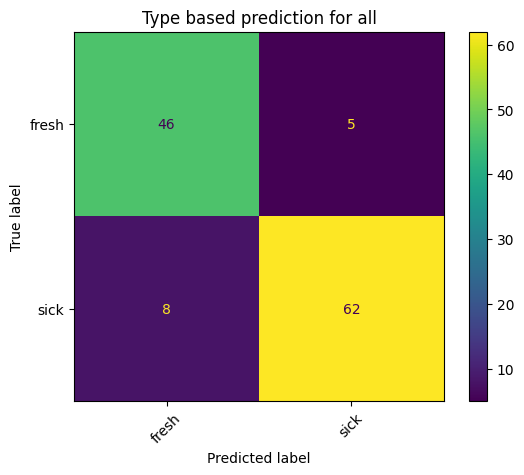

In [58]:
test_outputs = predict(test_ds)
draw_confusion_matrix(test_outputs)

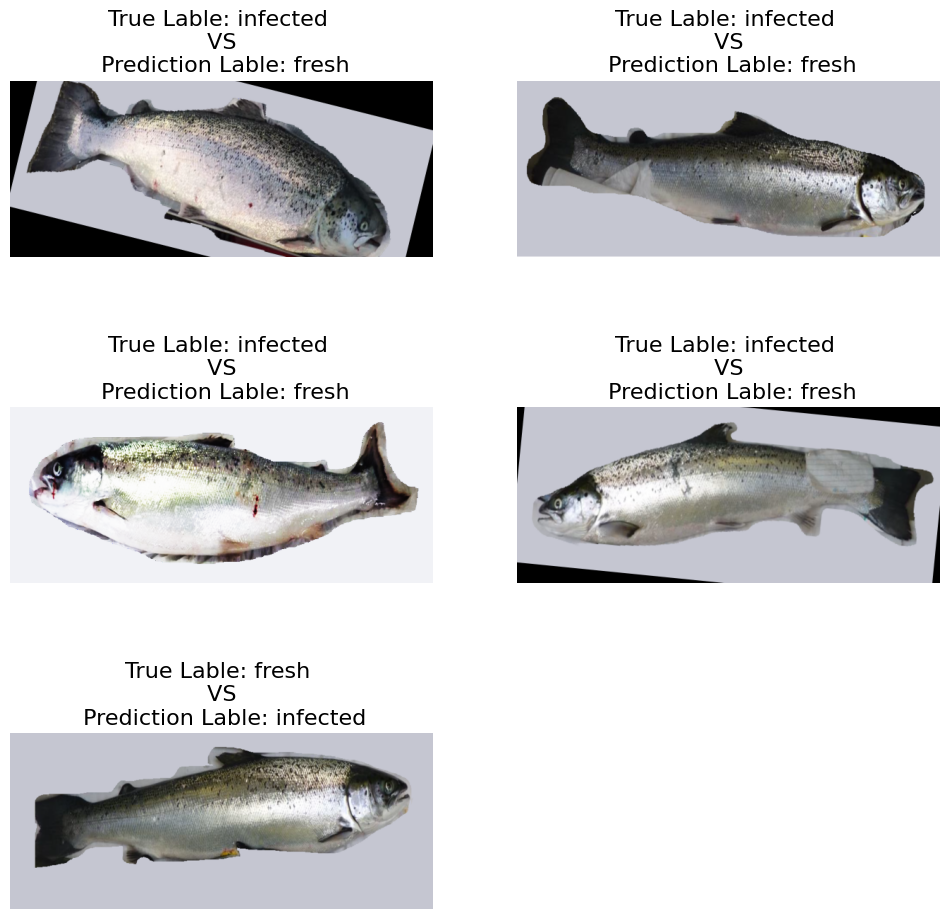

In [60]:
show_mislabeled_image(test_outputs, dataset=test_ds, num = 5)

# Explainable AI

## Explainable AI with SHAP

In [61]:
!pip install shap
import shap

In [62]:
from datasets import Dataset
topk = 1
batch_size = 10
n_evals = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def predict_no_grad(input):
    # Forward pass to get predictions
    model_input = {"pixel_values": nhwc_to_nchw(torch.tensor(input)).to(device), "labels": None}#torch.tensor(label).to(device)
    with torch.no_grad():
      output = model(**model_input)
      logits = output['logits']
    return logits


In [63]:
import json
import random
import string
from typing import Optional

import matplotlib.pyplot as pl
import numpy as np
from matplotlib.colors import Colormap

try:
    from IPython.display import HTML, display
    have_ipython = True
except ImportError:
    have_ipython = False

import shap
from shap import Explanation
from shap.utils import ordinal_str
from shap.plots import colors
from shap import kmeans



def image_plot(shap_values: Explanation or np.ndarray,
          pixel_values: Optional[np.ndarray] = None,
          labels: Optional[list or np.ndarray] = None,
          true_labels: Optional[list] = None,
          width: Optional[int] = 20,
          aspect: Optional[float] = 0.2,
          hspace: Optional[float] = 0.2,
          labelpad: Optional[float] = None,
          cmap: Optional[str or Colormap] = colors.red_transparent_blue,
          show: Optional[bool] = True):
    """Plots SHAP values for image inputs.

    Parameters
    ----------
    shap_values : [numpy.array]
        List of arrays of SHAP values. Each array has the shape
        (# samples x width x height x channels), and the
        length of the list is equal to the number of model outputs that are being
        explained.

    pixel_values : numpy.array
        Matrix of pixel values (# samples x width x height x channels) for each image.
        It should be the same
        shape as each array in the ``shap_values`` list of arrays.

    labels : list or np.ndarray
        List or ``np.ndarray`` (# samples x top_k classes) of names for each of the
        model outputs that are being explained.

    true_labels: list
        List of a true image labels to plot.

    width : float
        The width of the produced matplotlib plot.

    labelpad : float
        How much padding to use around the model output labels.

    show : bool
        Whether ``matplotlib.pyplot.show()`` is called before returning.
        Setting this to ``False`` allows the plot
        to be customized further after it has been created.

    """

    # support passing an explanation object
    if str(type(shap_values)).endswith("Explanation'>"):
        shap_exp = shap_values
        # feature_names = [shap_exp.feature_names]
        # ind = 0
        if len(shap_exp.output_dims) == 1:
            shap_values = [shap_exp.values[..., i] for i in range(shap_exp.values.shape[-1])]
        elif len(shap_exp.output_dims) == 0:
            shap_values = shap_exp.values
        else:
            raise Exception("Number of outputs needs to have support added!! (probably a simple fix)")
        if pixel_values is None:
            pixel_values = shap_exp.data
        if labels is None:
            labels = shap_exp.output_names

    # multi_output = True
    if not isinstance(shap_values, list):
        # multi_output = False
        shap_values = [shap_values]

    if len(shap_values[0].shape) == 3:
        shap_values = [v.reshape(1, *v.shape) for v in shap_values]
        pixel_values = pixel_values.reshape(1, *pixel_values.shape)

    # labels: (rows (images) x columns (top_k classes) )
    if labels is not None:
        if isinstance(labels, list):
            labels = np.array(labels).reshape(1, -1)

    label_kwargs = {} if labelpad is None else {'pad': labelpad}

    # plot our explanations
    x = pixel_values
    fig_size = np.array([4 * (len(shap_values) + 1), 2.5 * (x.shape[0] + 1)])
    if fig_size[0] > width:
        fig_size *= width / fig_size[0]
    fig, axes = pl.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
    if len(axes.shape) == 1:
        axes = axes.reshape(1, axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure we have a 2D array for grayscale
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])

        # if x_curr.max() > 1:
        #     x_curr /= 255.

        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (
                    0.2989 * x_curr[:, :, 0] + 0.5870 * x_curr[:, :, 1] + 0.1140 * x_curr[:, :, 2])  # rgb to gray
            x_curr_disp = x_curr
        elif len(x_curr.shape) == 3:
            x_curr_gray = x_curr.mean(2)

            # for non-RGB multi-channel data we show an RGB image where each of the three channels is a scaled k-mean center
            flat_vals = x_curr.reshape([x_curr.shape[0] * x_curr.shape[1], x_curr.shape[2]]).T
            flat_vals = (flat_vals.T - flat_vals.mean(1)).T
            means = kmeans(flat_vals, 3, round_values=False).data.T.reshape([x_curr.shape[0], x_curr.shape[1], 3])
            x_curr_disp = (means - np.percentile(means, 0.5, (0, 1))) / (
                    np.percentile(means, 99.5, (0, 1)) - np.percentile(means, 1, (0, 1)))
            x_curr_disp[x_curr_disp > 1] = 1
            x_curr_disp[x_curr_disp < 0] = 0
        else:
            x_curr_gray = x_curr
            x_curr_disp = x_curr

        axes[row, 0].imshow(x_curr_disp, cmap=pl.get_cmap('gray'))
        if true_labels:
            axes[row, 0].set_title(true_labels[row], **label_kwargs)
        axes[row, 0].axis('off')
        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
        else:
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row, i + 1].set_title(labels[row, i], **label_kwargs)
            # print(f"the shape of (shap_values[i][row].shape): {shap_values[i][row].shape}")
            sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
            # print(f"the shape of sv: {sv.shape}")
            axes[row, i + 1].imshow(x_curr_gray, cmap=pl.get_cmap('gray'), alpha=0.15,
                                    extent=(-1, sv.shape[1], sv.shape[0], -1))
            im = axes[row, i + 1].imshow(sv, cmap=cmap, vmin=-max_val, vmax=max_val)
            axes[row, i + 1].axis('off')
    if hspace == 'auto':
        fig.tight_layout()
    else:
        fig.subplots_adjust(hspace=hspace)
    cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal",
                      aspect=fig_size[0] / aspect)
    cb.outline.set_visible(False)
    if show:
        pl.show()


In [64]:
def explain_results_all(ds, n_evals=10, batch_size=10, topk=1):
  shap_values_list = []
  shap_output_list = []

  # define a masker that is used to mask out partitions of the input image.
  masker_blur = shap.maskers.Image("blur(128, 128)", (224,224,3))#test_image['pixel_values'].shape

  # create an explainer with model and image masker
  explainer = shap.Explainer(predict_no_grad, masker_blur, output_names=['fresh', 'infected'])
  input_data = nchw_to_nhwc(torch.stack(ds['pixel_values'], dim=0)).numpy()

  shapvalues = explainer(
    input_data,
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
  )
  values = [val for val in np.moveaxis(shapvalues.values, -1, 0)]

  shap_values = np.array(values)
  shap_output_names = np.array(shapvalues.output_names)
  shap_values = shap_values.reshape((topk, len(ds['image']), 224, 224, 3))
  shap_values_list = [val for val in shap_values]#!! important, cannot be np.array, otherwise the program will wrap it wih list
  images = ds['image']
  transform = Resize((224, 224))
  images = transform(images)
  image_arrays = [np.array(image) for image in images]
  images = np.stack(image_arrays, axis=0)
  id_type = {0: 'fresh', 1: 'infected'}
  output_names_list = []
  for id in range(shap_output_names.shape[0]):
    output_names = shap_output_names[id]
    if len(output_names) == 1 and len(ds['image']) != 1:#in case all the labels are the same, only one will be kept
      output_names = ([output_names for i in range(len(ds['image']))])
    output_names_list.append(output_names)
  output_names_list = np.array(output_names_list)
  image_plot(
      shap_values=shap_values_list,#need to be [numpy.array]
      pixel_values=images,
      labels=output_names_list,
      true_labels=ds['label'],
      width = 54,
  )

In [67]:
explain_results_all(test_ds[:], n_evals=10000)

Output hidden; open in https://colab.research.google.com to view.

## Interpretability with Captum

Compare interpretability for Transfer Learning


In [69]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 111.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [70]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule
from matplotlib.colors import LinearSegmentedColormap

### Gradient-based attribution





####  Integrated Gradients

In [71]:
def predict_with_grad(input):
    global PATTERN_ID
    model_input = {"pixel_values": input, "labels": None}#torch.tensor(label).to(device)

    # Forward pass to get predictions
    with torch.enable_grad():
      output = model(**model_input)
      logits = output['logits']
    # print(f"predict: PATTERN_ID: {PATTERN_ID}")
    return logits.view(-1, 2)

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform_ds = collate_fn(_val_transforms(test_ds))

Pred Labels [1]
True Labels 1
[True]


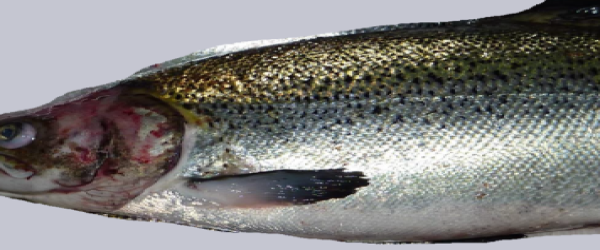

In [76]:
input_id = 23
input = {'pixel_values': transform_ds['pixel_values'][input_id:input_id+1], 'labels': transform_ds['labels'][input_id:input_id+1]}
output = model(input['pixel_values'].to('cuda'), input['labels'].to('cuda'))
output = output['logits'].view(-1, 2)
prediction_score, pred_label_idx = torch.topk(output.view(-1, 2), 1)
pred_label_idx = pred_label_idx.view(-1)
print('Pred Labels', pred_label_idx.tolist())
print('True Labels', test_ds[input_id]['label'])
correct = list(map(lambda x, y: x == y, pred_label_idx.tolist(), [test_ds[input_id]['label']]))
print(correct)
test_ds[input_id]['image']

In [42]:
test_ds[input_id]['label']

1

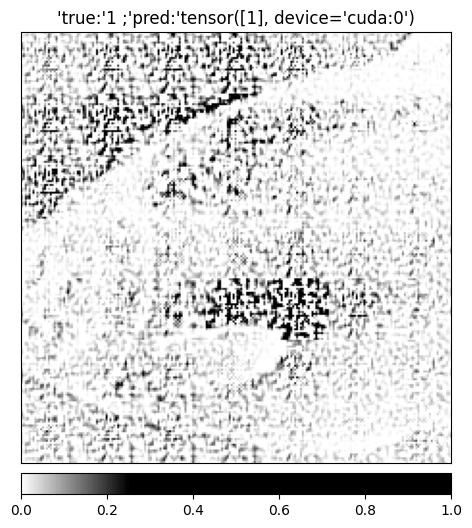

In [77]:
target = pred_label_idx
integrated_gradients = IntegratedGradients(predict_with_grad)

attributions_ig = integrated_gradients.attribute(input['pixel_values'].to('cuda'), target=target, n_steps=200)
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                [(0, '#ffffff'),
                                                (0.25, '#000000'),
                                                (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                            np.transpose(test_ds[input_id]['image'], (1,2,0)),
                            method='heat_map',
                            cmap=default_cmap,
                            show_colorbar=True,
                            sign='positive',
                            outlier_perc=1,
                            title=f"'true:'{test_ds[input_id]['label']} ;'pred:'{pred_label_idx}")
plt.imshow(test_ds[input_id]['image'])
plt.title(f"'true:'{test_ds[input_id]['label']} ;'pred:'{pred_label_idx}")
